<a href="https://colab.research.google.com/github/MD-ARIF-073/Bankruptcy-Prediction/blob/main/Bankruptcy_Prediction_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

We will be using data from the Taiwan Economic Journal on company financial statuses from 1999 to 2009 from [Kaggle](https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction). Our target variable is if a company went bankrupt or not in order for our stakeholder, a Taiwanese hedge fund, to make better decisions towards short positions. We have a long list of predictors such as Gross profit, operating income, taxes, and many other features listed below. 


## Business Problem

Our stakeholder is a Taiwanese hedge fund looking to profit via short selling companies operating in Taiwan. Our business problem is a classification problem to predict if a company will go bankrupt in order to advise our stakeholder on whether or not they should decide to take a short position in a company. A short position is borrowing company stock, selling it, and buying it back when it's valued less than borrow price. It is imperative that we do not mistakenly build our model to classify companies as going bankrupt as it would result in huge financial losses since the hedge fund will need to pay back the amount of stock borrowed. In order to avoid misclassifying false positives, we will tune our model with respect to precision accordingly.

## Data Understanding and Exploration

Below we will import the libraries we used in this notebook and then import and display the data.

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import plot_roc_curve, auc, precision_score, accuracy_score, recall_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost



import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.37,0.42,0.41,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.15,0.15,0.15,0.17,0.31,0.02,0.10,0.14,0.02,0.85,0.69,0.69,0.22,4980000000.00,0.00,0.26,0.36,0.00,0.00,0.63,0.02,0.21,0.79,0.01,0.39,0.01,0.10,0.14,0.40,0.09,0.00,0.00,0.00,0.00,0.03,0.03,0.39,0.04,0.67,0.17,0.19,0.00,0.00,0.00,0.15,0.33,0.28,0.00,0.68,0.72,0.34,0.03,0.90,0.00,0.06,701000000.00,6550000000.00,0.59,458000000.00,0.67,0.42,0.68,0.34,0.13,0.64,0.46,0.52,0.31,0.12,0,0.72,0.01,0.62,0.60,0.83,0.29,0.03,0.56,1,0.02
1,1,0.46,0.54,0.52,0.61,0.61,1.00,0.80,0.81,0.30,0.78,0.00,0.00,0.46,0.00,0.00,0.18,0.18,0.18,0.21,0.32,0.02,0.09,0.17,0.02,0.85,0.69,0.69,0.22,6110000000.00,0.00,0.26,0.38,0.01,0.00,0.64,0.01,0.17,0.83,0.01,0.38,0.01,0.09,0.17,0.40,0.06,0.00,0.00,9360000000.00,719000000.00,0.03,0.01,0.39,0.01,0.75,0.13,0.18,0.01,0.00,0.00,0.06,0.34,0.29,0.01,0.31,0.73,0.33,0.02,0.93,0.00,0.03,0.00,7700000000.00,0.59,2490000000.00,0.67,0.47,0.31,0.33,0.12,0.64,0.46,0.57,0.31,0.05,0,0.80,0.01,0.62,0.61,0.84,0.28,0.26,0.57,1,0.02
2,1,0.43,0.50,0.47,0.60,0.60,1.00,0.80,0.81,0.30,0.78,0.00,25500000.00,0.46,0.00,0.00,0.18,0.18,0.19,0.18,0.31,0.01,0.09,0.14,0.02,0.85,0.69,0.69,0.22,7280000000.00,0.00,0.26,0.37,0.01,0.01,0.63,0.02,0.21,0.79,0.01,0.38,0.01,0.09,0.15,0.41,0.01,0.00,0.00,65000000.00,2650000000.00,0.01,0.03,0.38,0.14,0.83,0.3

Below we can see that our dataset contains 6819 rows of data and 96 columns.

In [ ]:
df.shape

(6819, 96)

In [ ]:
print(df['Bankrupt?'].value_counts())
print(df['Bankrupt?'].value_counts(normalize=True))

0    6599
1     220
Name: Bankrupt?, dtype: int64
0   0.97
1   0.03
Name: Bankrupt?, dtype: float64


[Text(0, 0, 'Not Bankrupt'), Text(0, 0, 'Bankrupt')]

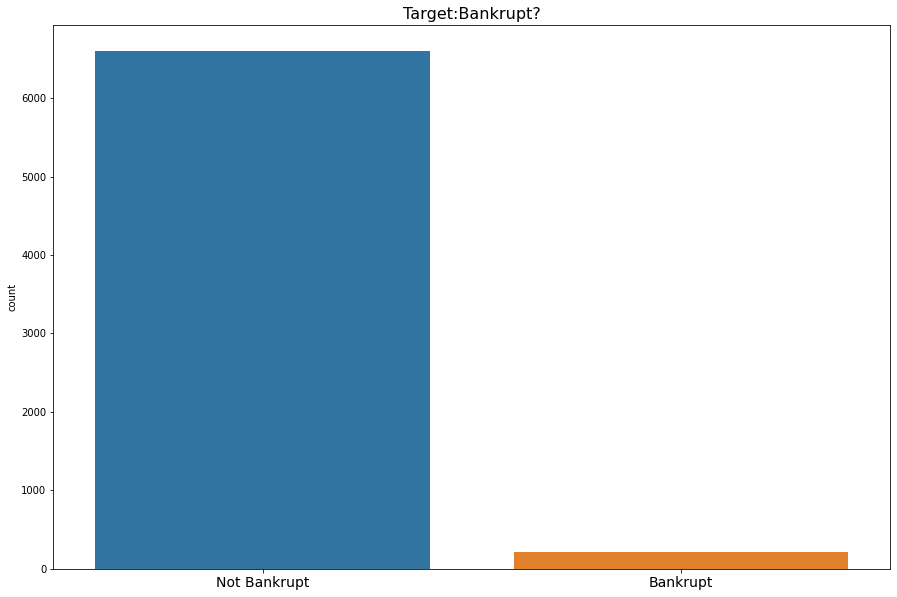

In [ ]:
#plt.style.use("dark_background")
#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(df['Bankrupt?'])
ax.set_title('Target:Bankrupt?', fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels(['Not Bankrupt', 'Bankrupt'], fontsize=14)


- 96% vs 3% - we will need to use an oversampling technique such as SMOTE as well as undersampling.

In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00
mean,0.03,0.51,0.56,0.55,0.61,0.61,1.00,0.80,0.81,0.30,0.78,1995347312.80,1950427306.06,0.47,16448012.91,0.12,0.19,0.19,0.19,0.23,0.32,1328640.60,0.11,0.18,0.02,0.85,0.69,0.69,0.22,5508096595.25,1566212.06,0.26,0.38,403284.95,8376594.82,0.63,4416336.71,0.11,0.89,0.01,0.37,0.01,0.11,0.18,0.40,0.14,12789705.24,9826220.86,2149106056.61,1008595981.82,0.04,2325854.27,0.40,11255785.32,0.81,0.40,0.52,0.12,3592902.20,37159994.15,0.09,0.35,0.28,55806804.53,0.76,0.74,0.33,54160038.14,0.93,0.00,0.03,1195855763.31,2163735272.03,0.59,2471976967.44,0.67,1220120.50,0.

We can observe we have quite a few outliers in some columns.

In [ ]:
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

- No missing values.

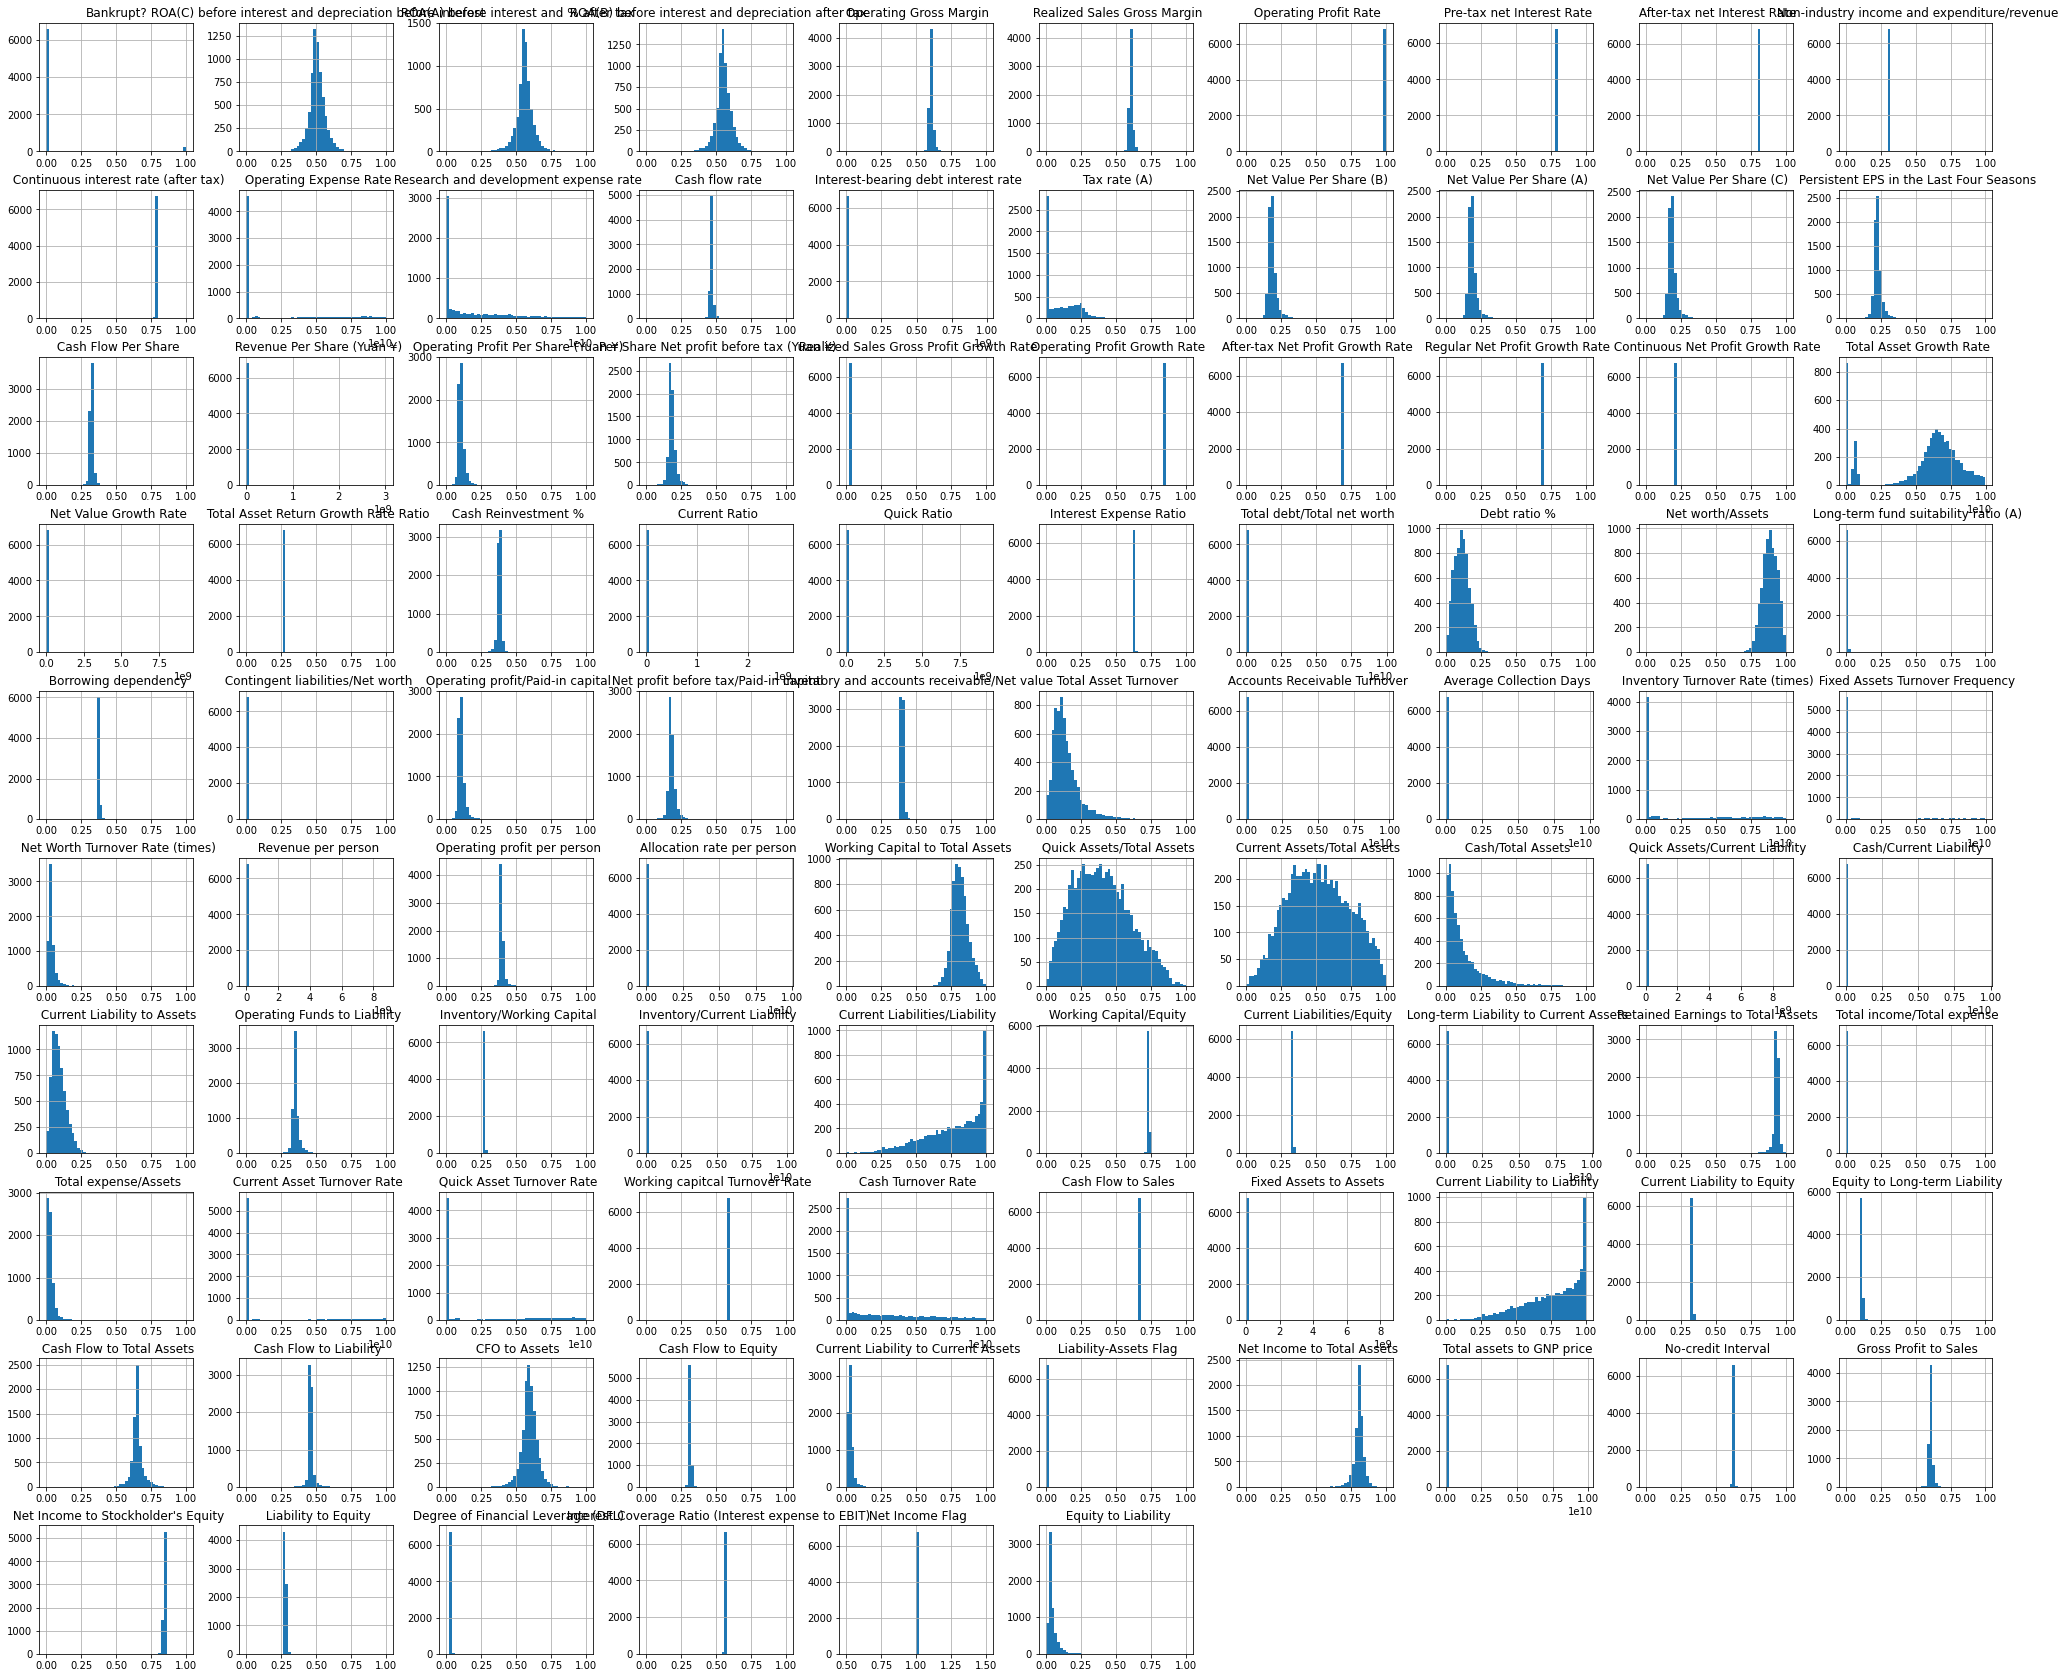

In [ ]:
df.hist(figsize = (35,30), bins = 50)
plt.show()


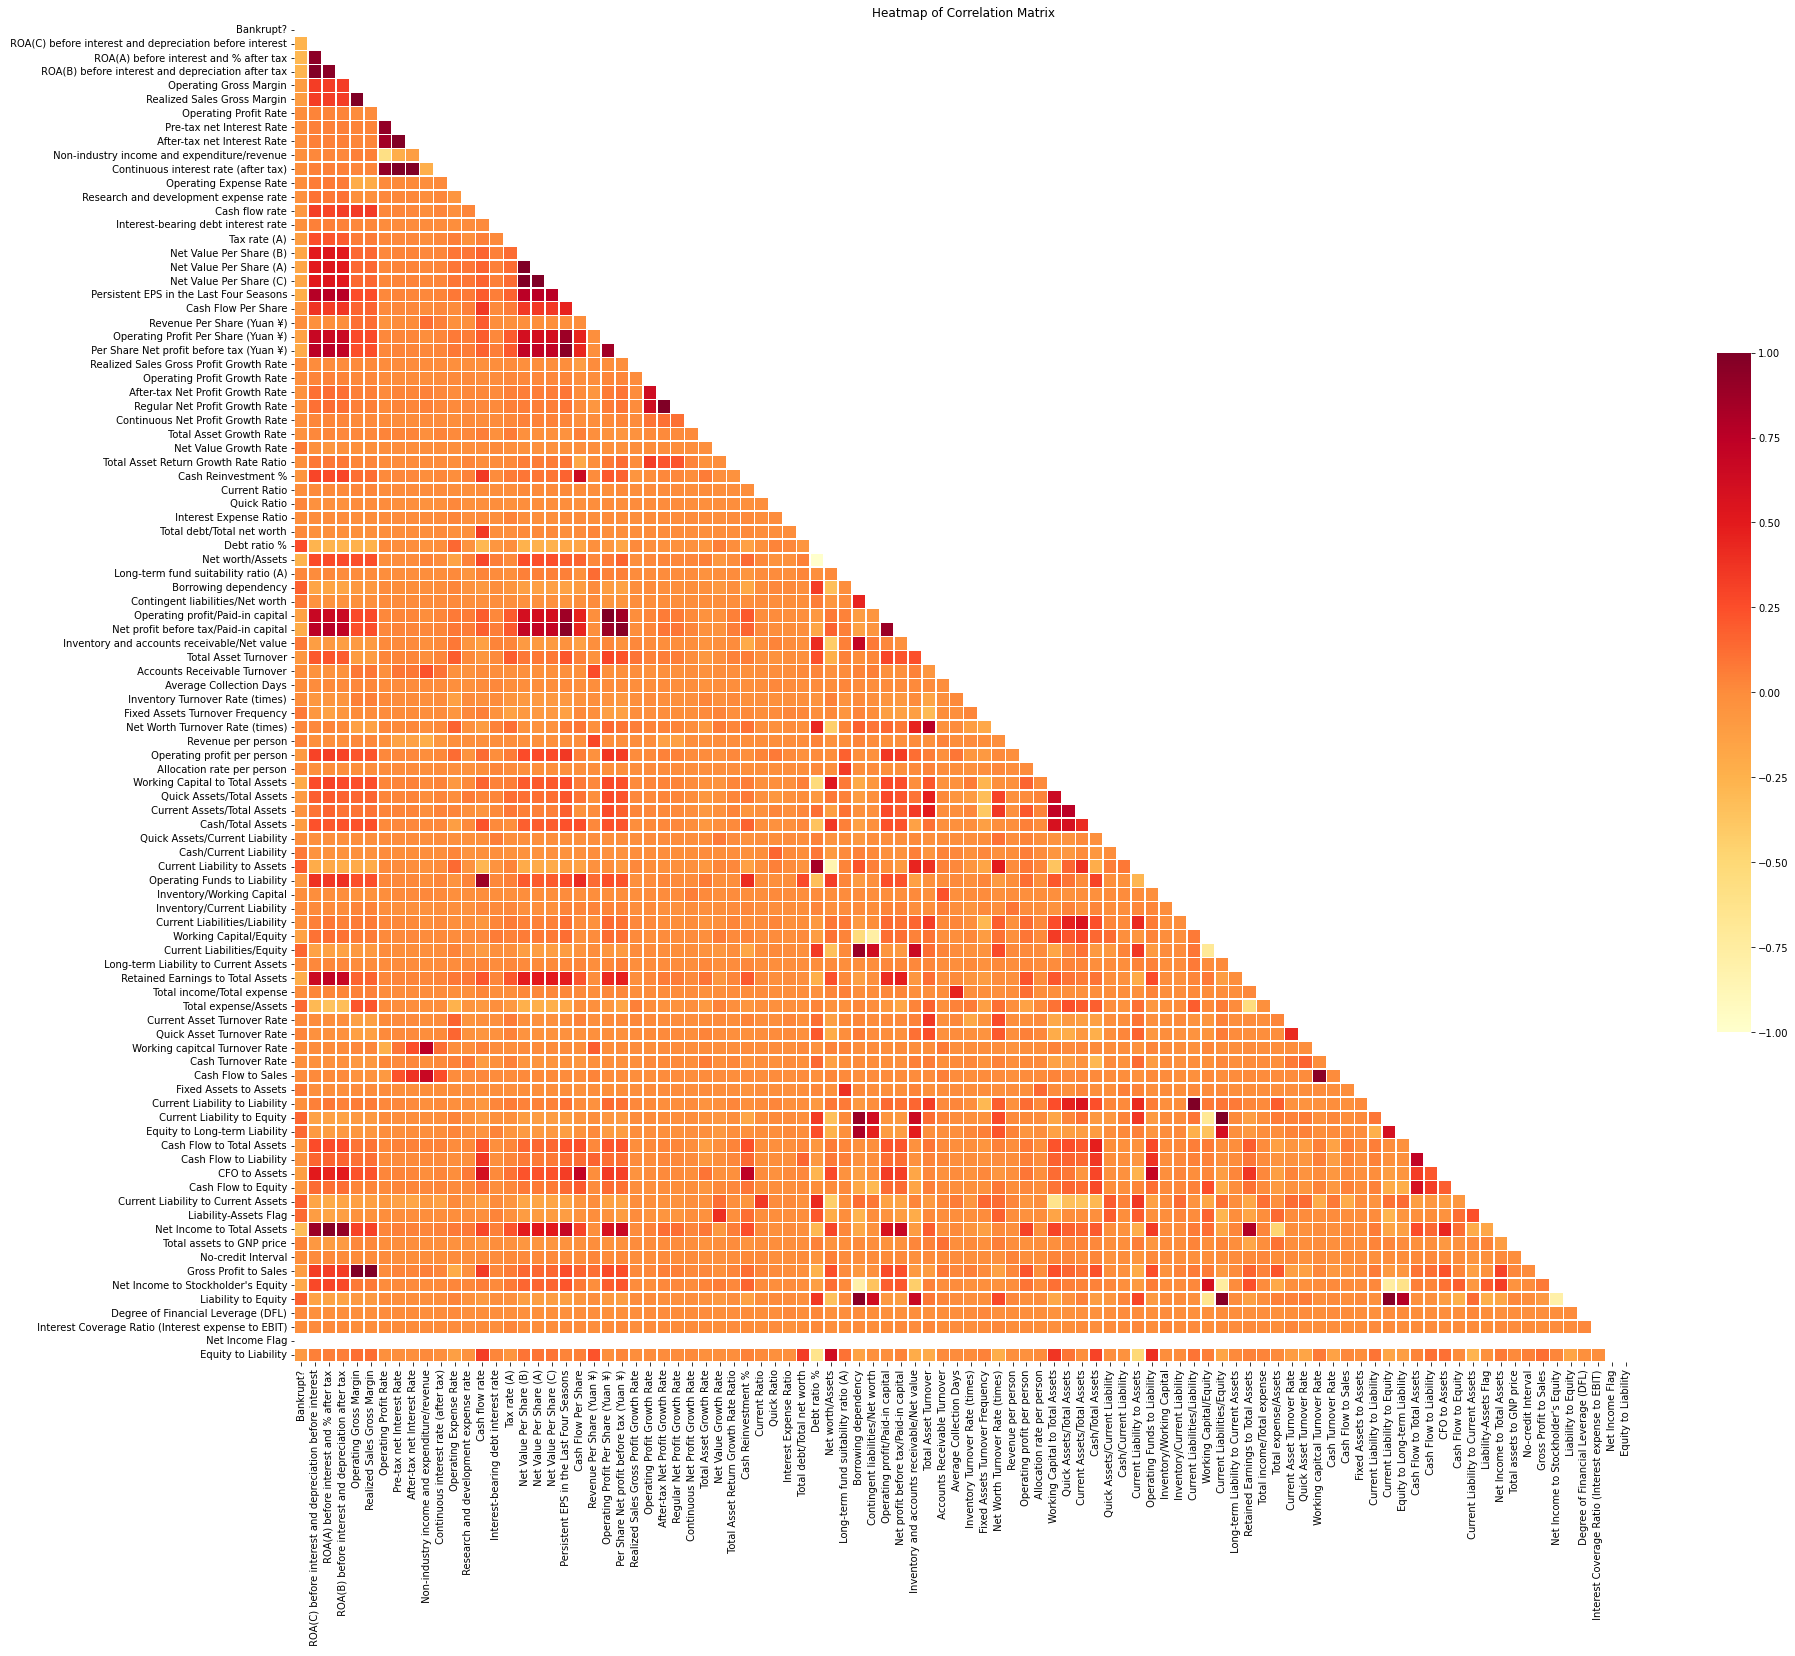

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(30,25))

sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)),
            ax=ax, cmap='YlOrRd', #annot=True, 
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title("Heatmap of Correlation Matrix");


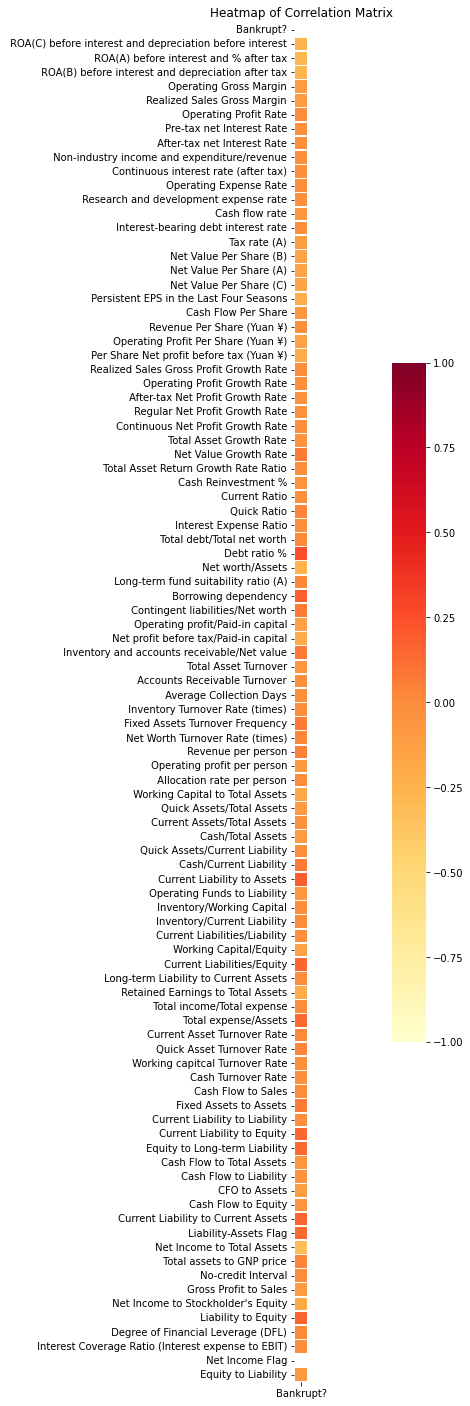

In [ ]:
corr2 = df.corr()

fig, ax = plt.subplots(figsize=(30,25))

sns.heatmap(data=corr2[['Bankrupt?']], mask=np.triu(np.ones_like(corr2[['Bankrupt?']], dtype=bool)),
            ax=ax, cmap='YlOrRd', #annot=True, 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

ax.set_title("Heatmap of Correlation Matrix");


In [ ]:
df.iloc[:, 94:95].value_counts()

 Net Income Flag
1                   6819
dtype: int64

- all values are 1 so we'll drop Net Income Flag
- we will also use the top 10 correlated features in our intiial models and compare against using all

In [ ]:
df.drop(' Net Income Flag', axis=1, inplace=True)

#### Exploring outliers using boxplot

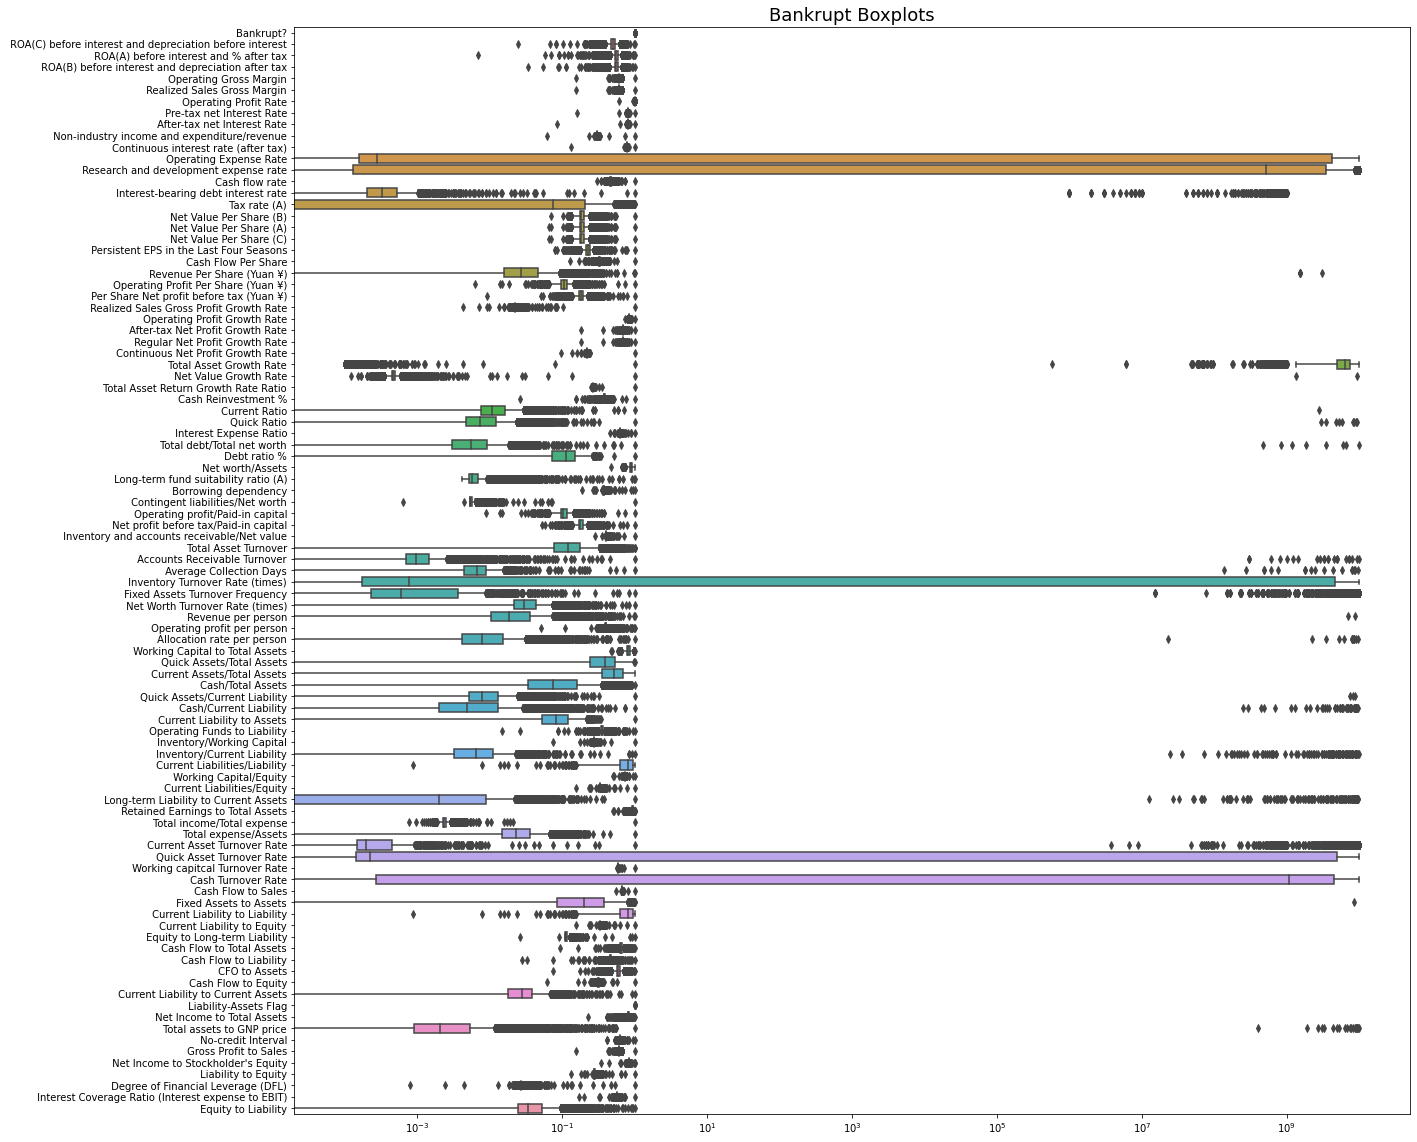

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))

ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bankrupt Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

#### Removing outliers

In [ ]:
def eli_outliers(col, col_name, df):
    print(col_name)
    q25, q75 = np.percentile(col, 25), np.percentile(col, 75)
    iqr = q75 - q25
    print(f"Q25 is {q25} and Q75 is {q75} | iqr is {iqr}")
    
    cutoff = iqr * 1.5
    lower_cutoff, upper_cutoff = q25 - cutoff, q75 + cutoff
    print(f"Cutoff is {cutoff} | Lower is {lower_cutoff} and Upper is {upper_cutoff}")
    
    outliers = [x for x in col if (x<lower_cutoff) or (x>upper_cutoff)]
    print(f"Number of outliers is {len(outliers)}")
    
    df = df.drop(df[(df[col_name] > upper_cutoff) | (df[col_name] < lower_cutoff)].index)
    print('-' * 65)
    
    return df

In [ ]:
for col in df:
    df_cleaned = eli_outliers(df[col], str(col), df)


Bankrupt?
Q25 is 0.0 and Q75 is 0.0 | iqr is 0.0
Cutoff is 0.0 | Lower is 0.0 and Upper is 0.0
Number of outliers is 220
-----------------------------------------------------------------
 ROA(C) before interest and depreciation before interest
Q25 is 0.476527080388047 and Q75 is 0.535562813825379 | iqr is 0.05903573343733198
Cutoff is 0.08855360015599797 | Lower is 0.38797348023204903 and Upper is 0.624116413981377
Number of outliers is 391
-----------------------------------------------------------------
 ROA(A) before interest and % after tax
Q25 is 0.53554295682512 and Q75 is 0.58915721761884 | iqr is 0.05361426079372
Cutoff is 0.08042139119058 | Lower is 0.45512156563454 and Upper is 0.66957860880942
Number of outliers is 561
-----------------------------------------------------------------
 ROA(B) before interest and depreciation after tax
Q25 is 0.527276620804112 and Q75 is 0.584105144815033 | iqr is 0.05682852401092098
Cutoff is 0.08524278601638147 | Lower is 0.4420338347877305 

In [ ]:
print(df_cleaned['Bankrupt?'].value_counts())
print(f'Shape {df_cleaned.shape}')

0    6052
1     218
Name: Bankrupt?, dtype: int64
Shape (6270, 95)


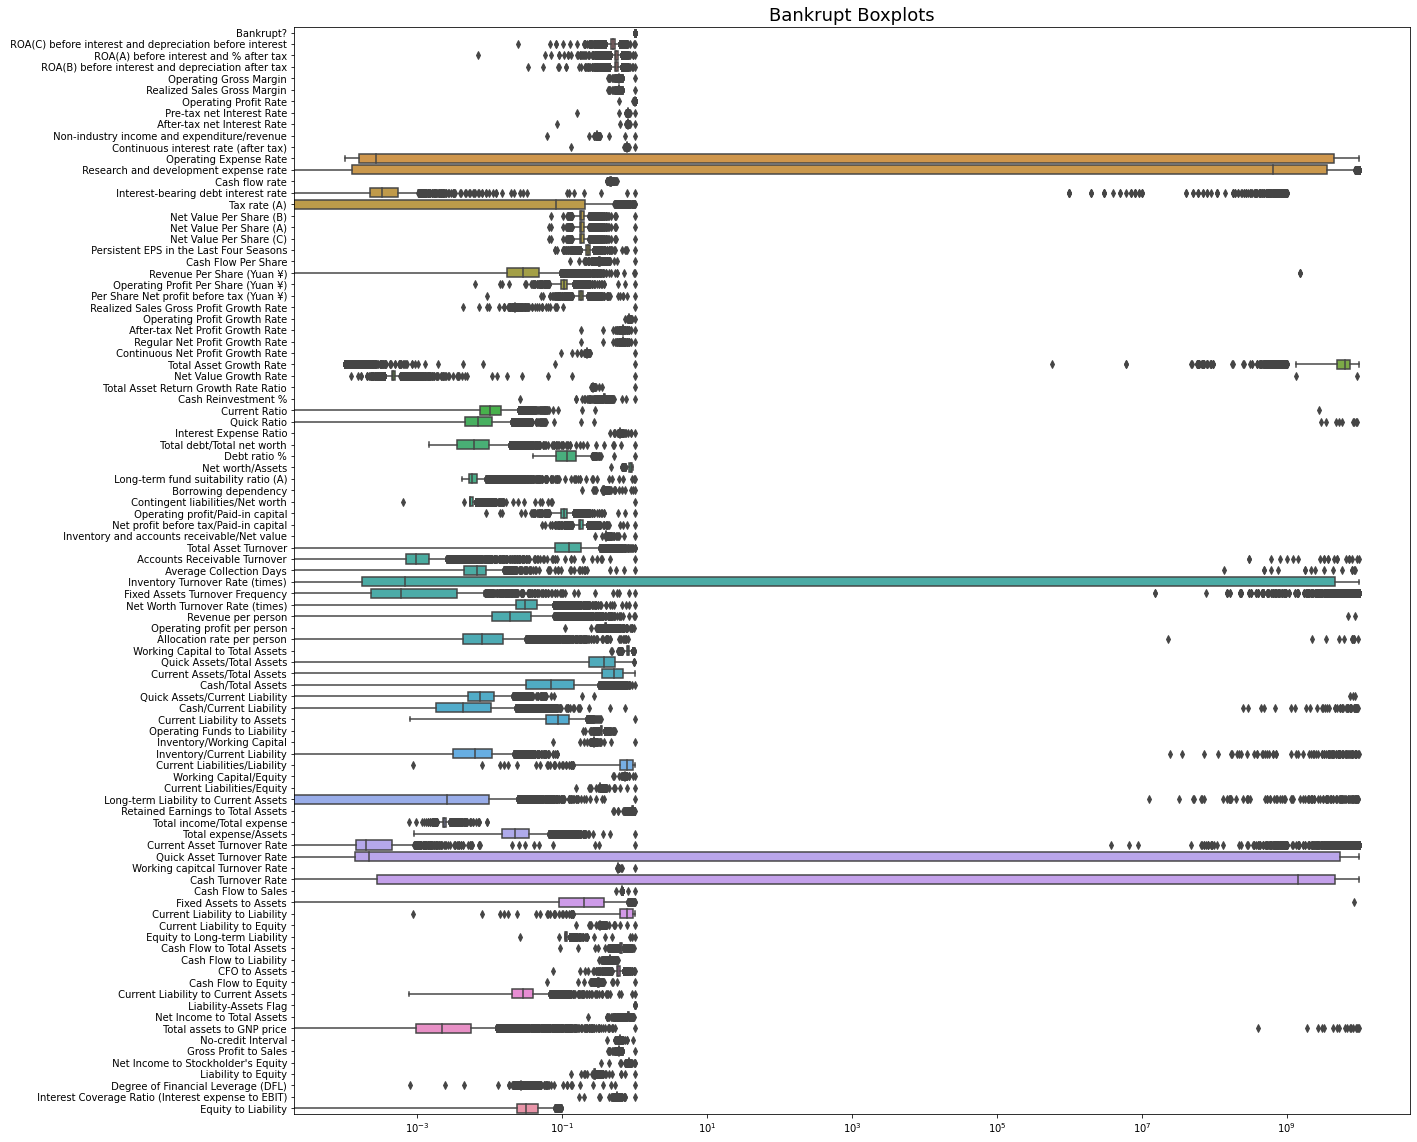

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))

ax =sns.boxplot(data = df_cleaned, orient="h")
ax.set_title('Bankrupt Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()


#### Exploring features containing debt or cash in the feature name as we have 96 columns and want to isolate ones we think are relevant

In [ ]:
matches = ["debt"]
debt_col = [col for col in df_cleaned.columns if any(x in col.lower() for x in matches)]
debt_col

[' Interest-bearing debt interest rate',
 ' Total debt/Total net worth',
 ' Debt ratio %']

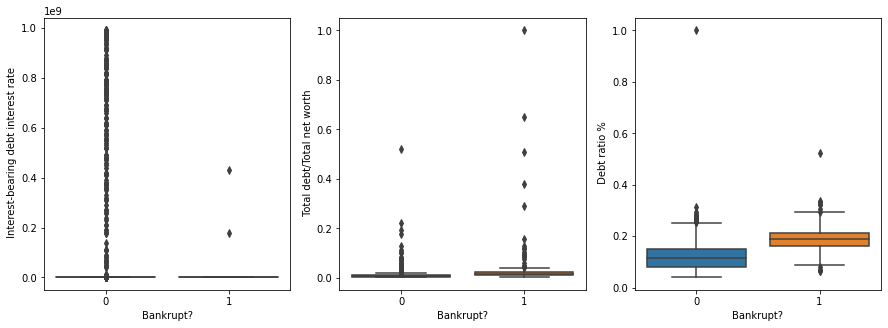

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax = sns.boxplot(x='Bankrupt?', y=' Interest-bearing debt interest rate', data=df_cleaned, ax=ax1)
ax = sns.boxplot(x='Bankrupt?', y=' Total debt/Total net worth', data=df_cleaned, ax=ax2)
ax = sns.boxplot(x='Bankrupt?', y=' Debt ratio %', data=df_cleaned, ax=ax3)

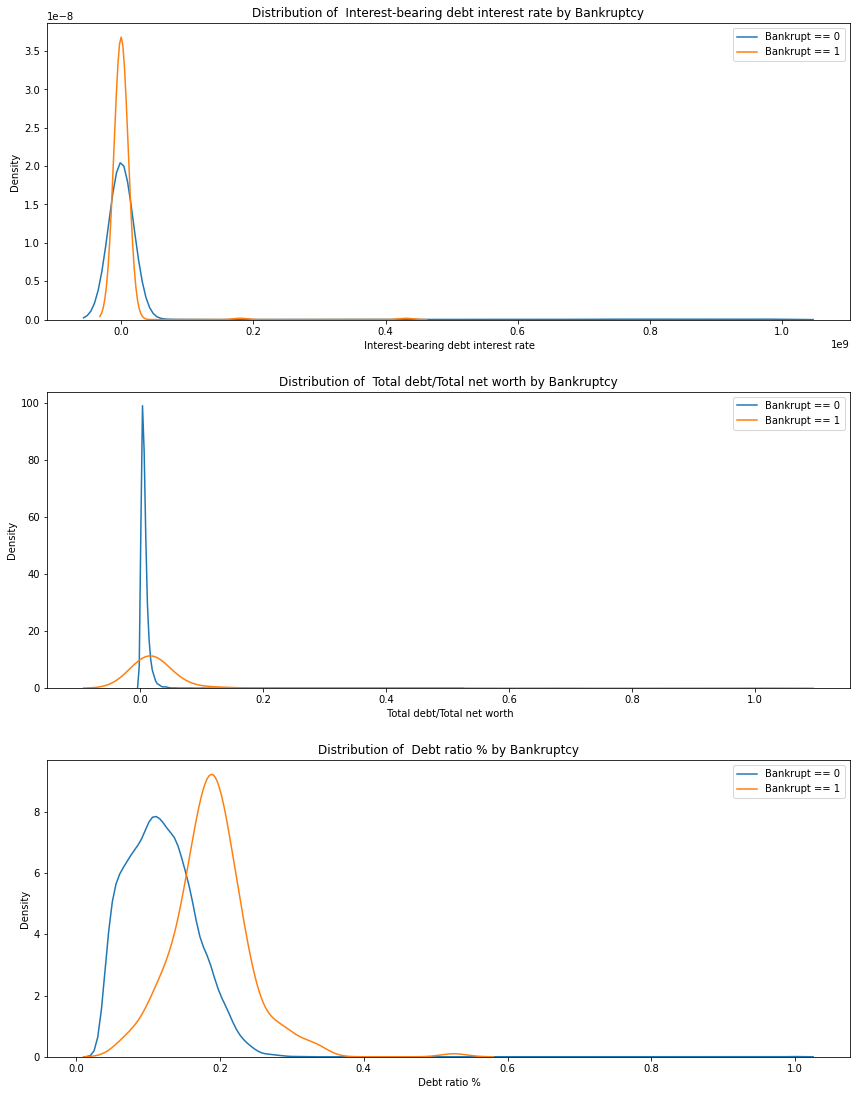

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate([' Interest-bearing debt interest rate', ' Total debt/Total net worth', ' Debt ratio %']):
    
    # create a new subplot for each feature
    plt.subplot(4, 1, i + 1)
    
    ax = sns.kdeplot(df_cleaned.loc[df_cleaned['Bankrupt?'] == 0, feature], label = 'Bankrupt == 0')
    ax = sns.kdeplot(df_cleaned.loc[df_cleaned['Bankrupt?'] == 1, feature], label = 'Bankrupt == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Bankruptcy' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    ax.legend()
    
plt.tight_layout(h_pad = 2.5)


#### Exploring top correlating features

In [ ]:
top_cor_col = corr2[["Bankrupt?"]].apply(abs).sort_values('Bankrupt?', ascending=False).iloc[1:11,:].index
list(top_cor_col)

[' Net Income to Total Assets',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Net worth/Assets',
 ' Debt ratio %',
 ' Persistent EPS in the Last Four Seasons',
 ' Retained Earnings to Total Assets',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)']

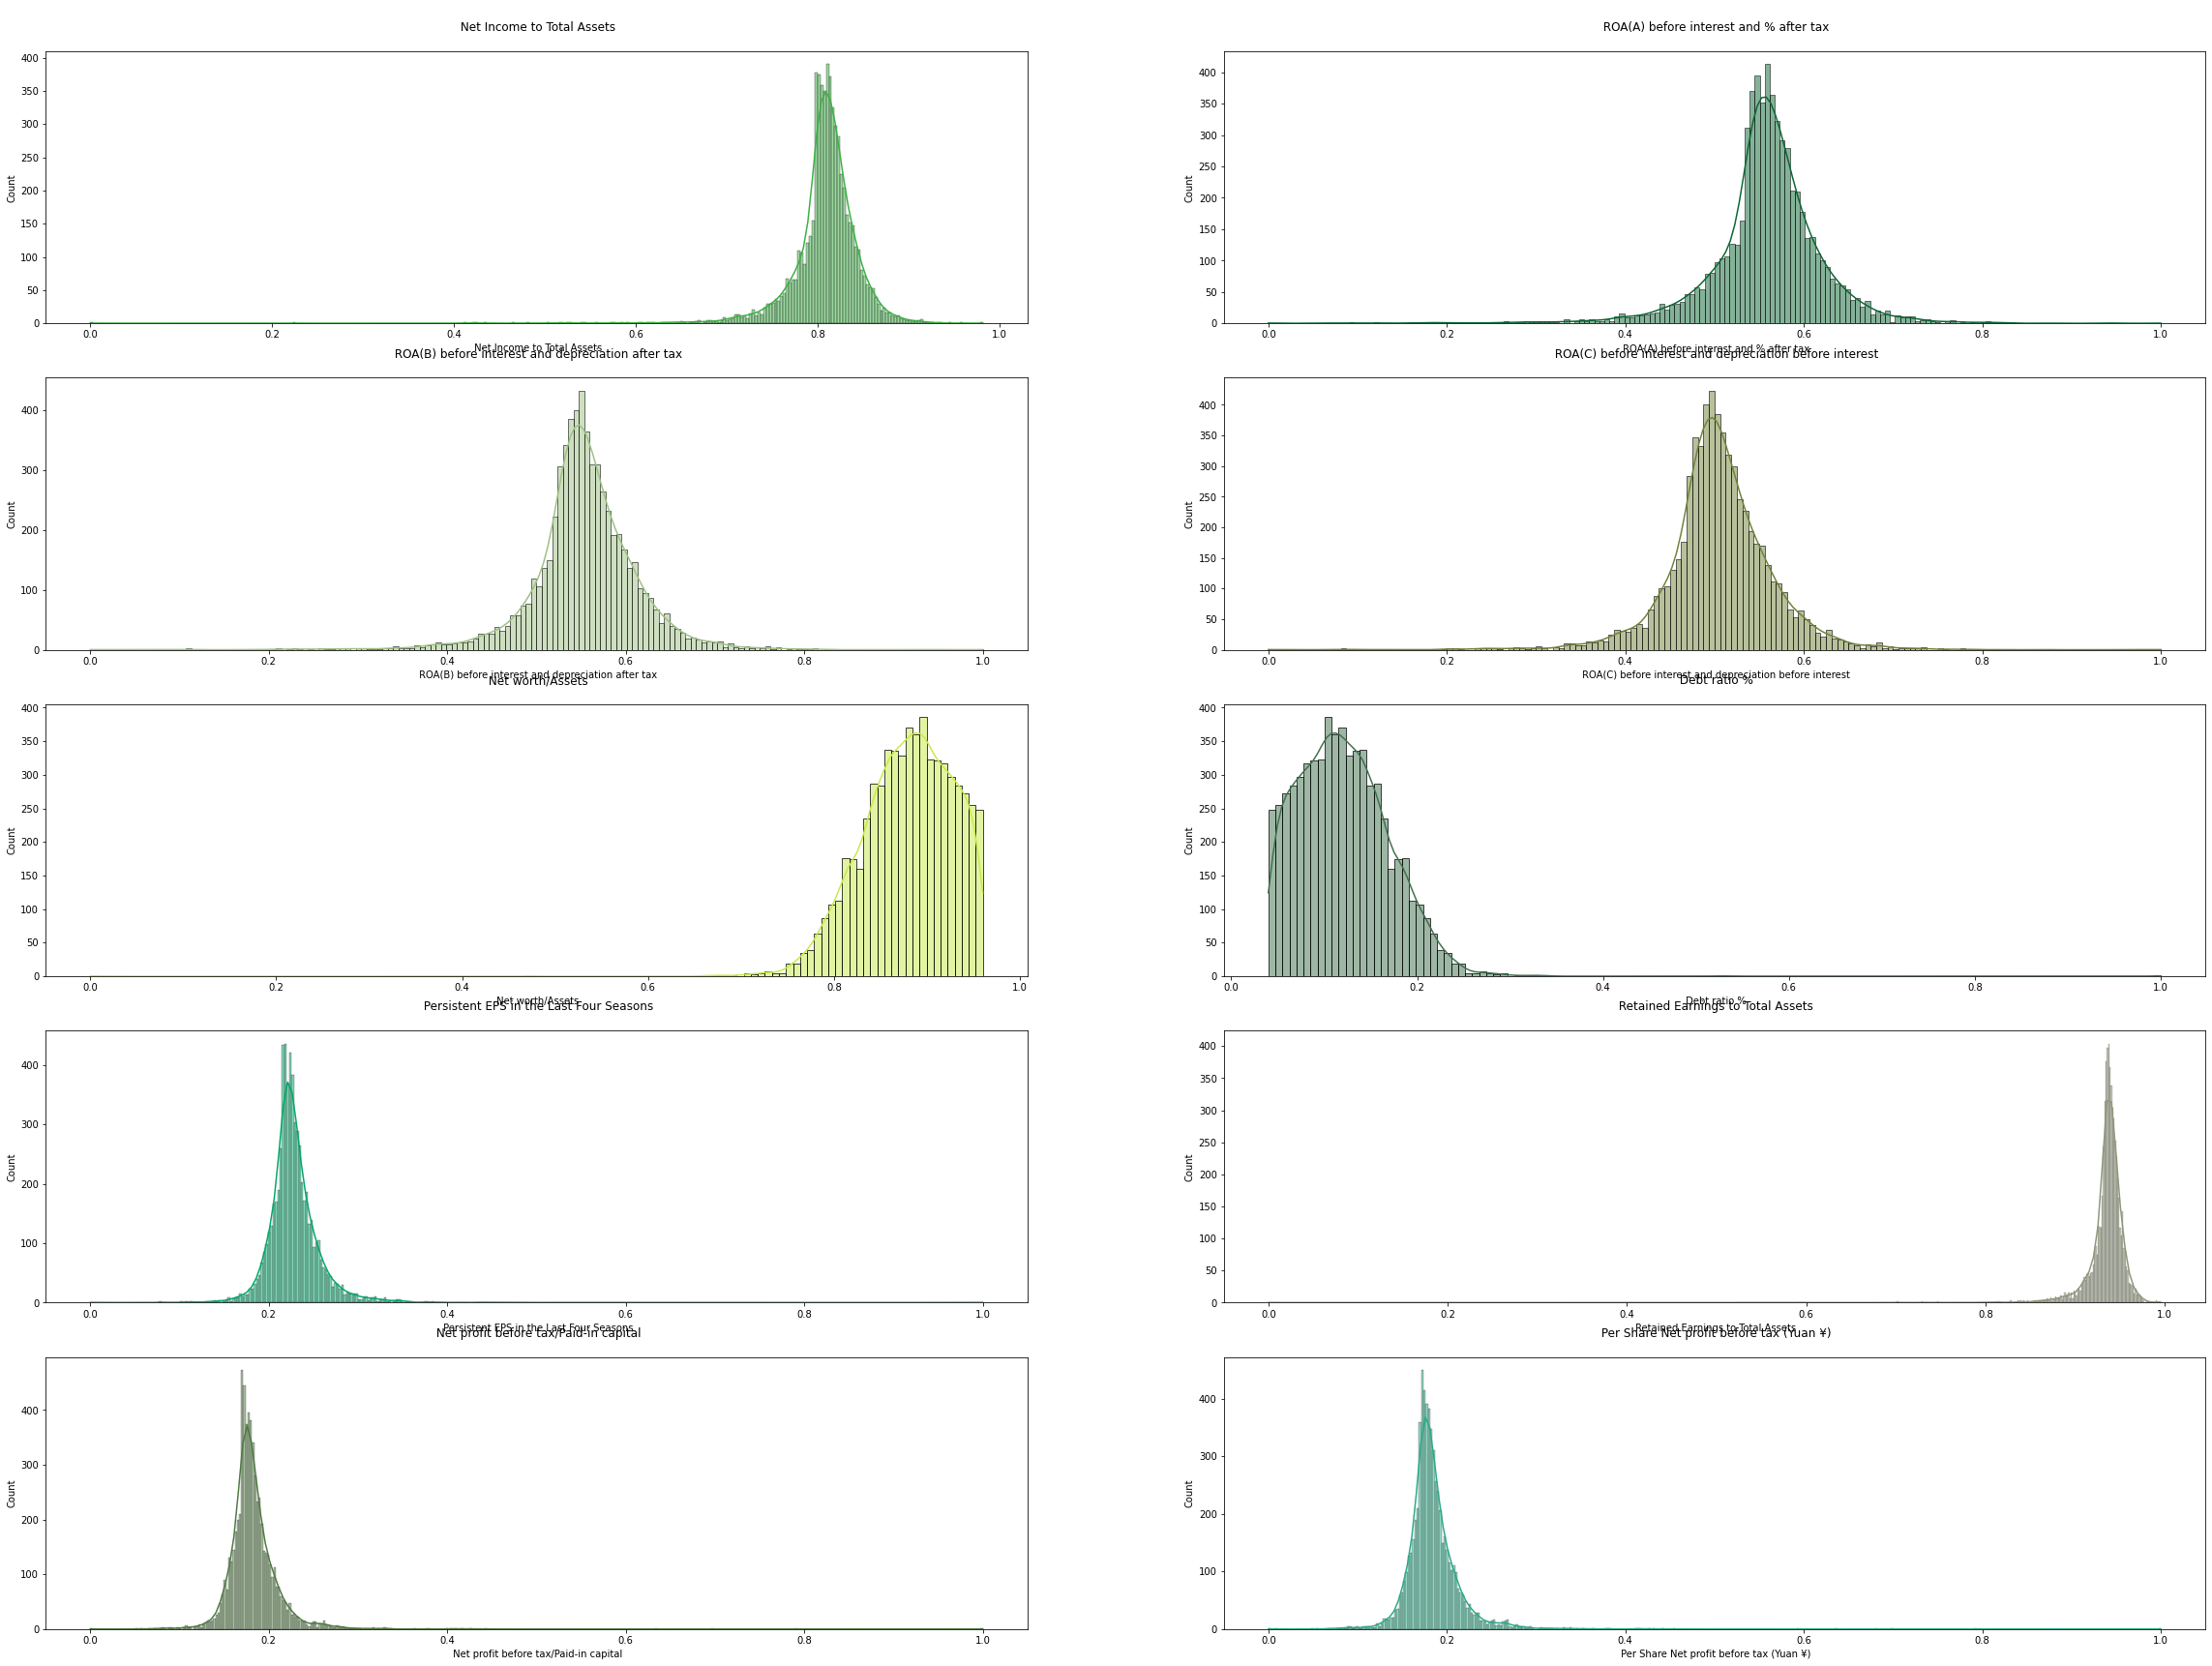

In [ ]:
fig, ax = plt.subplots(figsize=(40,30), ncols=2, nrows=5)

colors = ['#3BB143', '#0B6633', '#9DC183', '#708238', '#C7EA46',
          '#3F704D', '#00A86B', '#8F9779', '#4F7942', '#29AB87']

for i, column in enumerate(df_cleaned[list(top_cor_col)]):
    sns.histplot(df_cleaned[column], ax=ax[i//2, i%2], kde=True, color=colors[i])
    ax[i//2, i%2].set_title('\n' + column + '\n')

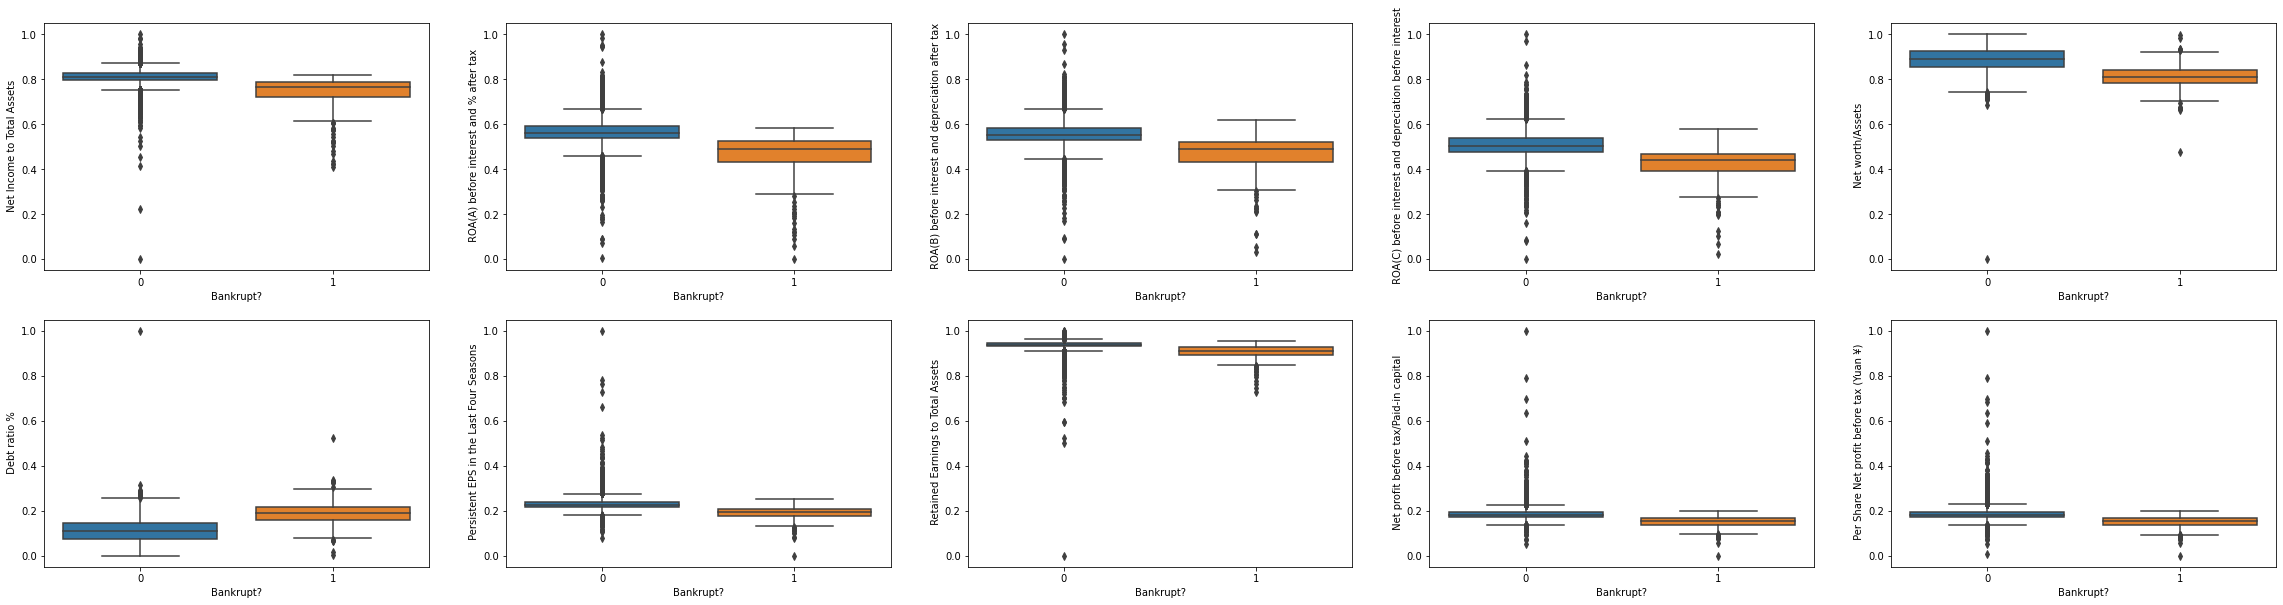

In [ ]:
fig, ax = plt.subplots(figsize=(40, 10), ncols=5, nrows=2)

for i, col in enumerate(df_cleaned[list(top_cor_col)]):
    sns.boxplot(x='Bankrupt?', y=col, data=df, ax=ax[i//5, i%5])

#### Distribution of the 10 features of 5 of the companies that went bankrupt

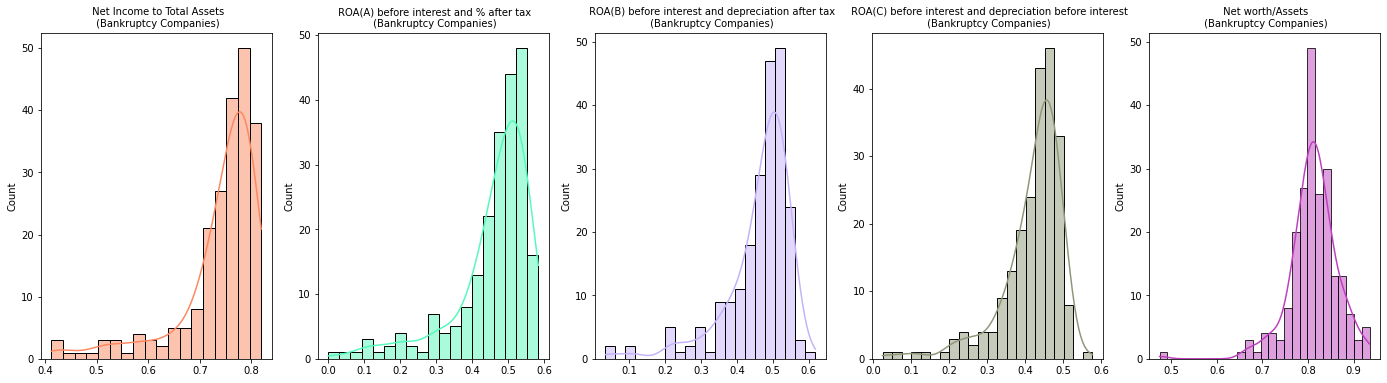

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(24, 6))
colors2 = ['#FB8861', '#56F9BB', '#C5B3F9', '#8F9779', '#bf40bf']

for i, col in enumerate(df_cleaned[list(top_cor_col[:5])]):
    bankrupt = df_cleaned[col].loc[df_cleaned['Bankrupt?'] == 1].values
    sns.histplot(bankrupt, ax=ax[i], kde=True, color=colors2[i])
    ax[i].set_title(col + '\n (Bankruptcy Companies)', fontsize=10)


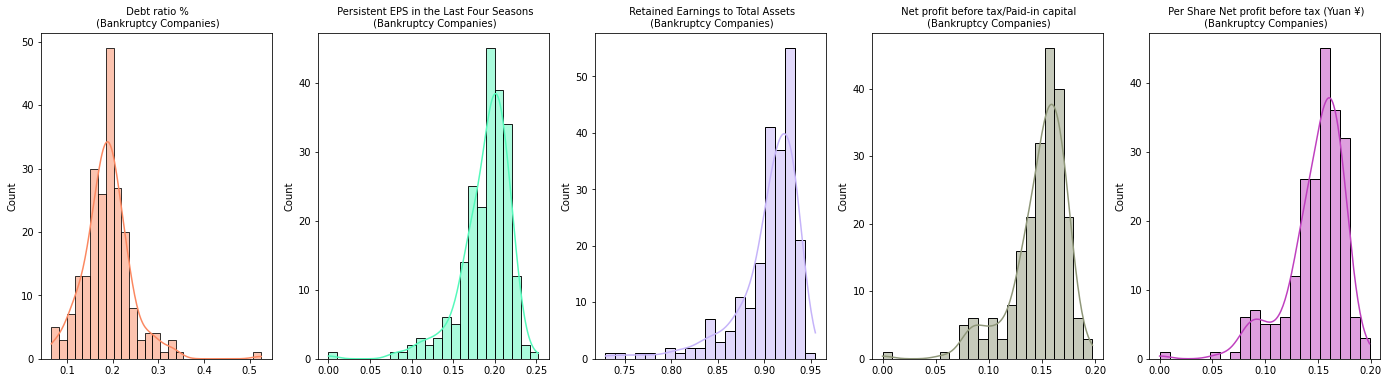

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(24, 6))
colors2 = ['#FB8861', '#56F9BB', '#C5B3F9', '#8F9779', '#bf40bf']

for i, col in enumerate(df_cleaned[list(top_cor_col[5:])]):
    bankrupt = df_cleaned[col].loc[df_cleaned['Bankrupt?'] == 1].values
    sns.histplot(bankrupt, ax=ax[i], kde=True, color=colors2[i])
    ax[i].set_title(col + '\n (Bankruptcy Companies)', fontsize=10)


### Splitting the Data

Below we will split our target from our predictors and train test split in order to leave a sample of the data for our model to test on at the end. Our dataset is about 6000 rows so we will keep our test size at 20% and train on 80% of the data.

In [ ]:
X = df_cleaned.drop('Bankrupt?', axis=1)
y = df_cleaned['Bankrupt?']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=4, 
                                                    stratify=y, 
                                                    test_size=.2)

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, 
                                   random_state=4, 
                                   shuffle=True)

### First logistic regression model with debt features 

#### Subsetting the training data with the debt features
- we want to start with a simple model with features we believe might have an impact on bankruptcy for companies.
- we implemented Standard Scaler into our pipeline because the column data are not all on the same scale and it would transform the data through standardizing

In [ ]:
debt_col

[' Interest-bearing debt interest rate',
 ' Total debt/Total net worth',
 ' Debt ratio %']

In [ ]:
X_train_debt = X_train[debt_col]
X_test_debt = X_test[debt_col]

In [ ]:
debt_steps = [('ss', StandardScaler()),
             ('debt', LogisticRegression(random_state=4))]

In [ ]:
debt_pipeline = Pipeline(debt_steps)
debt_pipeline.fit(X_train_debt, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('debt', LogisticRegression(random_state=4))])

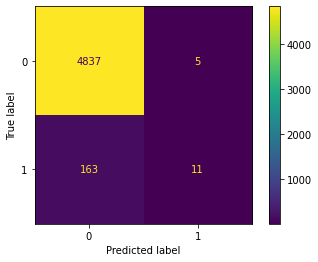

In [ ]:
plot_confusion_matrix(debt_pipeline, X_train_debt, y_train)

In [ ]:
print(classification_report(y_train, debt_pipeline.predict(X_train_debt)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       0.69      0.06      0.12       174

    accuracy                           0.97      5016
   macro avg       0.83      0.53      0.55      5016
weighted avg       0.96      0.97      0.95      5016



#### Our baseline model recall and precision score

In [ ]:
precision_score_base = precision_score(y_train, debt_pipeline.predict(X_train_debt))
recall_score_base = recall_score(y_train, debt_pipeline.predict(X_train_debt))

We will add our scores into these dictionaries as we iterate.

In [ ]:
recall_scores = {}
precision_scores = {}

In [ ]:
recall_scores['Baseline'] = {'Train':recall_score_base, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0}}

In [ ]:
precision_scores['Baseline'] = {'Train':precision_score_base, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0}}

#### Analysis of our Logistic Regression model using debt/liability features
In this model, we were able to achieve a precision score of 69% and a recall score of 6%. We are unable to succesfully predict if a company will go bankrupt. This might be due to the imbalance in our targe minority class. We will further explore other features that are correlated with our target and class balancing to see if our model improves. 

### Logistic Regression Model with top 10 features

#### Subsetting the training data with the top 10 features
- we want to explore if the correlated features would yield a better fitting model

In [ ]:
X_train_top_10 = X_train[top_cor_col]
X_test_top_10 = X_test[top_cor_col]

In [ ]:
top_10_steps = [('ss', StandardScaler()),
             ('top_10', LogisticRegression(random_state=4))]

In [ ]:
top_10_pipeline = Pipeline(top_10_steps)

In [ ]:
top_10_cv = cross_validate(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring=['precision', 'neg_log_loss'])

In [ ]:
top_10_cv

{'fit_time': array([0.04389954, 0.05051708, 0.03641653, 0.04072905, 0.03510618]),
 'score_time': array([0.00656366, 0.00711584, 0.00612116, 0.00990248, 0.00408506]),
 'test_precision': array([0.57142857, 0.54545455, 0.53333333, 0.21052632, 1.        ]),
 'test_neg_log_loss': array([-0.1030833 , -0.11551538, -0.10776766, -0.1322051 , -0.09698759])}

In [ ]:
cv10_ = cross_val_score(top_10_pipeline, 
                           X_train_top_10, y_train, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision')

In [ ]:
cv10_.mean()

0.5721485532011847

In [ ]:
top_10_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('top_10', LogisticRegression(random_state=4))])

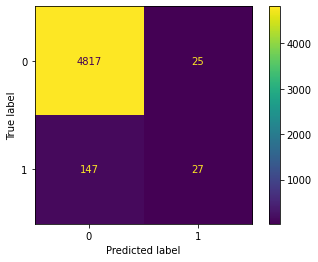

In [ ]:
plot_confusion_matrix(top_10_pipeline, X_train_top_10, y_train);

In [ ]:
print(classification_report(y_train, top_10_pipeline.predict(X_train_top_10)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4842
           1       0.52      0.16      0.24       174

    accuracy                           0.97      5016
   macro avg       0.74      0.58      0.61      5016
weighted avg       0.95      0.97      0.96      5016



In [ ]:
recall_score_top_10 = recall_score(y_train, top_10_pipeline.predict(X_train_top_10))
recall_scores['Top 10'] = {'Train':recall_score_top_10, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0}}

In [ ]:
precision_score_top_10 = precision_score(y_train, top_10_pipeline.predict(X_train_top_10))
precision_scores['Top 10'] = {'Train':precision_score_top_10, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0}}

#### Analysis of model with top 10 features
Like our first model, we were unable to correctly predict many of the comopanies that went bankrupt. This might be due to the imbalance in the dataset which we will explore next.

### Logistic regression with Class Weight 
- We will use grid search to find the best class weights to rebalance the minority class and majority class while continuing to use top 10 features.

In [ ]:
cw_steps = [('ss', StandardScaler()),
             ('cw', LogisticRegression(random_state=4))]

In [ ]:
cw_pipeline = Pipeline(cw_steps)
cw_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('cw', LogisticRegression(random_state=4))])

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                  shuffle=True,
                                  random_state=4)

weights = np.linspace(0.0,0.99,200)

In [ ]:
cw_grid = {'cw__class_weight':[{0:x, 1:1.0-x} for x in weights]}

In [ ]:
cw_grid_search = GridSearchCV(estimator=cw_pipeline,
                                param_grid=cw_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [ ]:
cw_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('cw',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'cw__class_weight': [{0: 0.0, 1: 1.0},
                                              {0: 0.004974874371859297,
                                               1: 0.9950251256281407},
                                              {0: 0.009949748743718593,
                                               1: 0.9900502512562814},
                                              {0: 0.014924623115577889,
                                               1: 0.98507537...
                                              {0: 0.11442211055276383,
                                               1: 0.8855778894472361},
                                              {0: 0.11939698492462311,
            

In [ ]:
cw_grid_search.best_params_

{'cw__class_weight': {0: 0.870603015075377, 1: 0.12939698492462304}}

Text(0.5, 1.0, 'Scoring for different class weights')

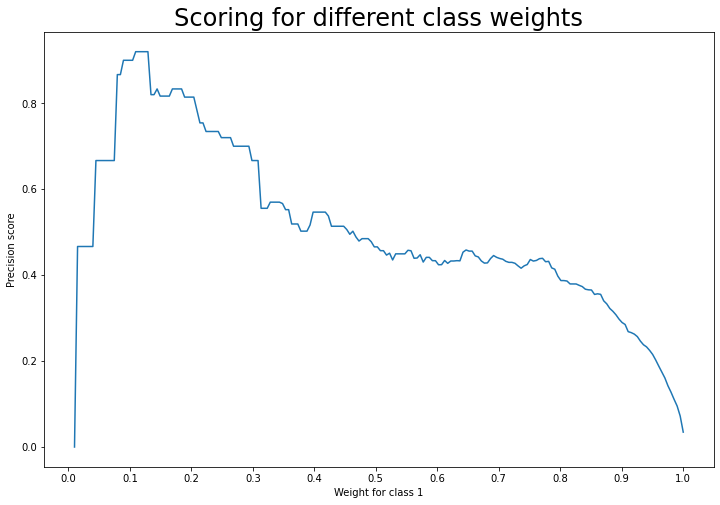

In [ ]:
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': cw_grid_search.cv_results_['mean_test_precision'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)


In [ ]:
best_cw_steps = [('ss', StandardScaler()),
             ('cw', LogisticRegression(random_state=4, class_weight={0: 0.870603015075377, 1: 0.12939698492462304}))]

In [ ]:
best_cw_pipeline = Pipeline(best_cw_steps)

In [ ]:
best_cw_cv = cross_validate(best_cw_pipeline, 
                            X_train_top_10, y_train, 
                            cv=stratified_kfold, 
                            n_jobs=-1, 
                            scoring=['precision', 'neg_log_loss'])

In [ ]:
best_cw_cv

{'fit_time': array([0.05156207, 0.04934931, 0.05461836, 0.05579996, 0.02483368]),
 'score_time': array([0.00735497, 0.00876522, 0.0071733 , 0.00699949, 0.00409269]),
 'test_precision': array([1. , 1. , 0.6, 1. , 1. ]),
 'test_neg_log_loss': array([-0.15314538, -0.13971449, -0.14612865, -0.12529045, -0.1409078 ])}

In [ ]:
best_cw_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('cw',
                 LogisticRegression(class_weight={0: 0.870603015075377,
                                                  1: 0.12939698492462304},
                                    random_state=4))])

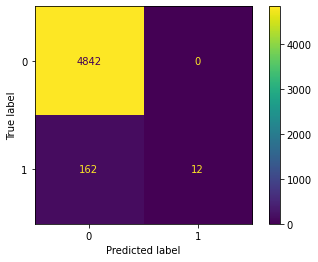

In [ ]:
plot_confusion_matrix(best_cw_pipeline, X_train_top_10, y_train);

In [ ]:
print(classification_report(y_train, best_cw_pipeline.predict(X_train_top_10)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       1.00      0.07      0.13       174

    accuracy                           0.97      5016
   macro avg       0.98      0.53      0.56      5016
weighted avg       0.97      0.97      0.95      5016



In [ ]:
recall_score_best_cw = recall_score(y_train, best_cw_pipeline.predict(X_train_top_10))
recall_scores['Class Weight'] = {'Train':recall_score_best_cw, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0}}

In [ ]:
precision_score_best_cw = precision_score(y_train, best_cw_pipeline.predict(X_train_top_10))
precision_scores['Class Weight'] = {'Train':precision_score_best_cw, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0}}

#### Analysis of class weight rebalancing
In this model, we were able to extract the best class weights via grid search cross validation. We minimized our false positives but still not able to correctly predict if a company went bankrupt.

### Modelling with Oversampling and Undersampling
- we will be using an oversampling method, SMOTE, and an undersampling methods to rebalance the classes since our minority class is only 3% vs the majority class' 97%.

In [ ]:
over_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('over', LogisticRegression(random_state=4))]

under_steps = [('undie', RandomUnderSampler(random_state=4)),
              ('ss', StandardScaler()),
              ('under', LogisticRegression(random_state=4))]

In [ ]:
over_pipeline = imbpipeline(over_steps)
under_pipeline = imbpipeline(under_steps)

In [ ]:
over_param_grid = {'over__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

under_param_grid = {'under__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [ ]:
over_grid_search = GridSearchCV(estimator=over_pipeline,
                                param_grid=over_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [ ]:
under_grid_search = GridSearchCV(estimator=under_pipeline,
                                 param_grid=under_param_grid,
                                 scoring=['precision', 'neg_log_loss'],
                                 cv=stratified_kfold,
                                 n_jobs=-1,
                                 refit='precision')

In [ ]:
over_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=4)),
                                       ('ss', StandardScaler()),
                                       ('over',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'over__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [ ]:
over_grid_search.score(X_train_top_10, y_train)

0.18969849246231155

In [ ]:
under_grid_search.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('undie',
                                        RandomUnderSampler(random_state=4)),
                                       ('ss', StandardScaler()),
                                       ('under',
                                        LogisticRegression(random_state=4))]),
             n_jobs=-1,
             param_grid={'under__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [ ]:
under_grid_search.score(X_train_top_10, y_train)

0.17445838084378562

In [ ]:
over_grid_search.best_params_

{'over__C': 1000}

In [ ]:
under_grid_search.best_params_

{'under__C': 10}

In [ ]:
best_over_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_over_over', LogisticRegression(C=1000,
                                         random_state=4))]
best_under_steps = [('smote', SMOTE(random_state=4)),
             ('ss', StandardScaler()),
             ('best_under_under', LogisticRegression(C=10,
                                         random_state=4))]

In [ ]:
best_over_pipeline = imbpipeline(best_over_steps)
best_under_pipeline = imbpipeline(best_under_steps)

In [ ]:
best_over_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_over_over', LogisticRegression(C=1000, random_state=4))])

In [ ]:
best_under_pipeline.fit(X_train_top_10, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=4)), ('ss', StandardScaler()),
                ('best_under_under', LogisticRegression(C=10, random_state=4))])

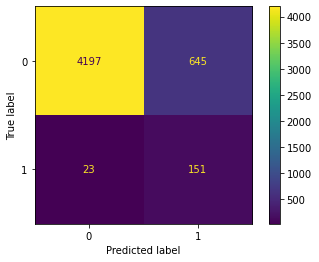

In [ ]:
plot_confusion_matrix(best_over_pipeline, X_train_top_10, y_train);

In [ ]:
recall_score_best_over = recall_score(y_train, best_over_pipeline.predict(X_train_top_10))
recall_scores['Oversampling'] = {'Train':recall_score_best_over, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0}}

In [ ]:
precision_score_best_over = precision_score(y_train, best_over_pipeline.predict(X_train_top_10))
precision_scores['Oversampling'] = {'Train':precision_score_best_over, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0}}

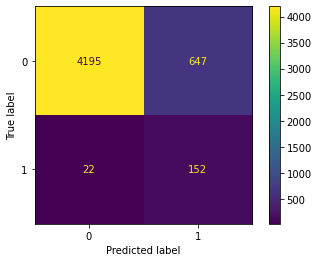

In [ ]:
plot_confusion_matrix(best_under_pipeline, X_train_top_10, y_train);

In [ ]:
precision_score_best_under = precision_score(y_train, best_under_pipeline.predict(X_train_top_10))
precision_scores['Undersampling'] = {'Train':precision_score_best_under, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0}}

In [ ]:
recall_score_best_under = recall_score(y_train, best_under_pipeline.predict(X_train_top_10))
recall_scores['Undersampling'] = {'Train':recall_score_best_under, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0}}

#### Analysis of Over and  Under Sampling
We can see that our over and under sampling methods yielded lower precision scores and higher recall scores than our class weight parameter and we'll proceed with using class weight.

### Fourth model with all predictors using our best parameters and under sampling

In [ ]:
all_steps = [('ss', StandardScaler()),
              ('all', LogisticRegression(random_state=4, 
                                         class_weight={0: 0.870603015075377,
                                                       1: 0.12939698492462304}))]

In [ ]:
all_pipeline = Pipeline(all_steps)

In [ ]:
all_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('all',
                 LogisticRegression(class_weight={0: 0.870603015075377,
                                                  1: 0.12939698492462304},
                                    random_state=4))])

In [ ]:
all_cv = cross_validate(all_pipeline, 
                        X_train, y_train, 
                        scoring=['precision', 'neg_log_loss'], 
                        cv=stratified_kfold, 
                        n_jobs=-1)

In [ ]:
all_cv

{'fit_time': array([0.13442206, 0.13237834, 0.11864114, 0.12131882, 0.07472777]),
 'score_time': array([0.01273704, 0.01195645, 0.01222229, 0.01088858, 0.00681853]),
 'test_precision': array([0.33333333, 1.        , 0.55555556, 0.5       , 0.66666667]),
 'test_neg_log_loss': array([-0.14856858, -0.13745143, -0.14201381, -0.16624701, -0.13302841])}

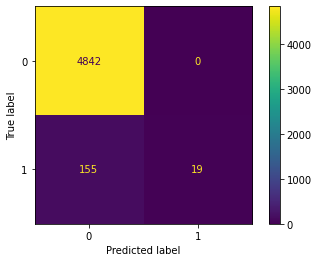

In [ ]:
plot_confusion_matrix(all_pipeline, X_train, y_train);

In [ ]:
precision_score_all = precision_score(y_train, all_pipeline.predict(X_train))
precision_scores['All Features'] = {'Train':precision_score_all, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0}}

In [ ]:
recall_score_all = recall_score(y_train, all_pipeline.predict(X_train))
recall_scores['All Features'] = {'Train':recall_score_all, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0}}

In [ ]:
print(classification_report(y_train, all_pipeline.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4842
           1       1.00      0.11      0.20       174

    accuracy                           0.97      5016
   macro avg       0.98      0.55      0.59      5016
weighted avg       0.97      0.97      0.96      5016



### Random Forests

We will continue running our model with a random forest classifier because it's a powerful ensemble method of classification.

In [ ]:
weights = np.linspace(0.0,0.99,200)

In [ ]:
rfc_balanced = RandomForestClassifier(bootstrap=False,
                                    criterion='entropy', 
                                    max_depth=10, 
                                    max_leaf_nodes=100,
                                    random_state=4)

In [ ]:
rfc_balanced_param_grid = {'class_weight':[{0:x, 1:1.0-x} for x in weights]}

In [ ]:
rfc_balanced_gsCV = GridSearchCV(estimator=rfc_balanced,
                                param_grid=rfc_balanced_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='precision')

In [ ]:
rfc_balanced_gsCV.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy', max_depth=10,
                                              max_leaf_nodes=100,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115...
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                 

In [ ]:
rfc_balanced_gsCV_1 = GridSearchCV(estimator=rfc_balanced,
                                param_grid=rfc_balanced_param_grid,
                                scoring=['precision', 'neg_log_loss'],
                                cv=stratified_kfold,
                                n_jobs=-1,
                                refit='neg_log_loss')

In [ ]:
rfc_balanced_gsCV_1.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy', max_depth=10,
                                              max_leaf_nodes=100,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115...
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                           1: 0.8806030150753769},
                                 

In [ ]:
rfc_balanced_gsCV.best_params_

{'class_weight': {0: 0.99, 1: 0.010000000000000009}}

In [ ]:
rfc_balanced_gsCV_1.best_params_

{'class_weight': {0: 0.39798994974874374, 1: 0.6020100502512562}}

In [ ]:
confusion_matrix(y_train, rfc_balanced_gsCV.best_estimator_.predict(X_train_top_10))

array([[4842,    0],
       [ 127,   47]])

In [ ]:
rfc_best_balance = RandomForestClassifier(bootstrap=False,
                        class_weight={0: 0.39798994974874374, 1: 0.6020100502512562},
                        criterion='entropy', max_depth=10, max_leaf_nodes=100,
                        random_state=4)

In [ ]:
rfc_best_balance.fit(X_train_top_10, y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.39798994974874374,
                                     1: 0.6020100502512562},
                       criterion='entropy', max_depth=10, max_leaf_nodes=100,
                       random_state=4)

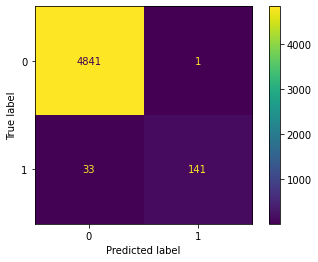

In [ ]:
plot_confusion_matrix(rfc_best_balance, X_train_top_10, y_train);

In [ ]:
recall_score_rfc_best_balance = recall_score(y_train, rfc_best_balance.predict(X_train_top_10))
recall_scores['Random Forest'] = {'Train':recall_score_rfc_best_balance, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0},
 'Random Forest': {'Train': 0.8103448275862069, 'Test': 0}}

In [ ]:
precision_score_rfc_best_balance = precision_score(y_train, rfc_best_balance.predict(X_train_top_10))
precision_scores['Random Forest'] = {'Train':precision_score_rfc_best_balance, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0},
 'Random Forest': {'Train': 0.9929577464788732, 'Test': 0}}

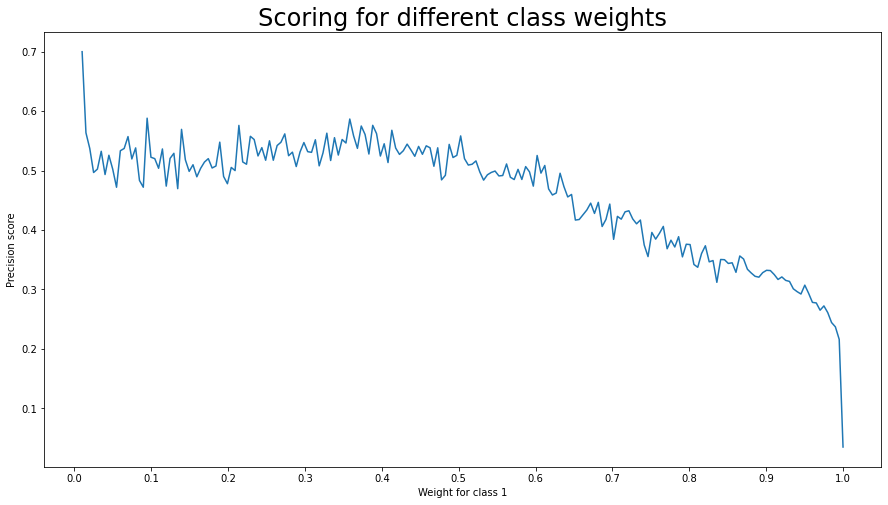

In [ ]:
plt.figure(figsize=(15,8))
weigh_data = pd.DataFrame({ 'score': rfc_balanced_gsCV_1.cv_results_['mean_test_precision'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
plt.savefig('/content/sample_data/cw_scores.jpg', bbox_inches='tight')

### XGBoost Model

- After using random forest, we will use eXtreme Gradient Boosting, XGBoost, a method of gradient boosting which is building weak learning models on top of each other to achieve a better result. 

In [ ]:
xgb_steps = [('sm', SMOTE(random_state=4)),
             ('xgb', xgboost.XGBClassifier(random_state=4))
            ]

In [ ]:
xgb_imbpipe = imbpipeline(xgb_steps)
                        

In [ ]:
xgb_params = {'xgb__eta' : [0.1,0.01,0.001],  # Learning rate
              'xgb__eval_metric': ['logloss'],
              'xgb__max_depth' : [3,6,9],
              'xgb__lambda' : [1,1.5,2],      # L2 regularization (higher values make model more conservative)
              'xgb__alpha' : [0,0.5,1]}


In [ ]:
xgb_gsCV = GridSearchCV(xgb_imbpipe,
                       xgb_params,
                       scoring=['precision', 'neg_log_loss'],
                       cv=stratified_kfold,
                       refit='precision',
                       n_jobs=-1)

In [ ]:
xgb_gsCV.fit(X_train_top_10, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=4)),
                                       ('xgb', XGBClassifier(random_state=4))]),
             n_jobs=-1,
             param_grid={'xgb__alpha': [0, 0.5, 1],
                         'xgb__eta': [0.1, 0.01, 0.001],
                         'xgb__eval_metric': ['logloss'],
                         'xgb__lambda': [1, 1.5, 2],
                         'xgb__max_depth': [3, 6, 9]},
             refit='precision', scoring=['precision', 'neg_log_loss'])

In [ ]:
xgb_gsCV.best_params_

{'xgb__alpha': 0,
 'xgb__eta': 0.1,
 'xgb__eval_metric': 'logloss',
 'xgb__lambda': 1,
 'xgb__max_depth': 9}

In [ ]:
xgb_best_steps = [('sm', SMOTE(random_state=4)),
             ('xgb', xgboost.XGBClassifier(random_state=4,
                                           alpha=1,
                                           eta=0.1,
                                           eval_metric='logloss',
                                           reg_lambda=1,
                                           max_depth=9))]

In [ ]:
xgb_best_pipe = imbpipeline(xgb_best_steps)

In [ ]:
xgb_best_pipe.fit(X_train_top_10, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=4)),
                ('xgb',
                 XGBClassifier(alpha=1, eta=0.1, eval_metric='logloss',
                               max_depth=9, random_state=4))])

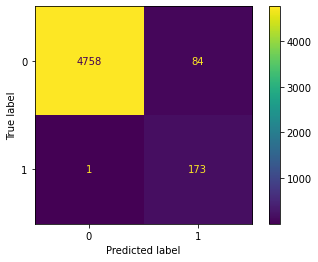

In [ ]:
plot_confusion_matrix(xgb_best_pipe, X_train_top_10, y_train);

In [ ]:
prob_pred_xgb = xgb_best_pipe.predict_proba(X_train_top_10)
prob_pred_xgb

array([[9.9978858e-01, 2.1141455e-04],
       [9.9682623e-01, 3.1737764e-03],
       [9.9022061e-01, 9.7793872e-03],
       ...,
       [9.9039572e-01, 9.6042845e-03],
       [7.8851819e-01, 2.1148179e-01],
       [9.9616653e-01, 3.8334944e-03]], dtype=float32)

In [ ]:
prob_0 = prob_pred_xgb[:,0]

In [ ]:
y_pred_xgb = np.where(prob_0 > 0.2, 0, 1)

In [ ]:
xgb_cf = confusion_matrix(y_train, y_pred_xgb)

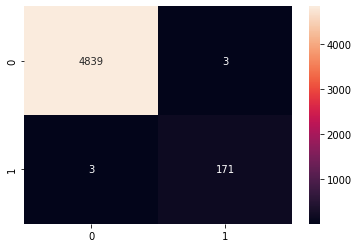

In [ ]:
sns.heatmap(xgb_cf, annot=True, fmt='d')

In [ ]:
precision_score_xgb_best_pipe = precision_score(y_train, (y_pred_xgb))
precision_scores['XGB Best'] = {'Train':precision_score_xgb_best_pipe, 'Test':0}
precision_scores

{'Baseline': {'Train': 0.6875, 'Test': 0},
 'Top 10': {'Train': 0.5192307692307693, 'Test': 0},
 'Class Weight': {'Train': 1.0, 'Test': 0},
 'Oversampling': {'Train': 0.18969849246231155, 'Test': 0},
 'Undersampling': {'Train': 0.1902377972465582, 'Test': 0},
 'All Features': {'Train': 1.0, 'Test': 0},
 'Random Forest': {'Train': 0.9929577464788732, 'Test': 0},
 'XGB Best': {'Train': 0.9827586206896551, 'Test': 0}}

In [ ]:
recall_score_xgb_best_pipe = recall_score(y_train, (y_pred_xgb))
recall_scores['XGB Best'] = {'Train':recall_score_xgb_best_pipe, 'Test':0}
recall_scores

{'Baseline': {'Train': 0.06321839080459771, 'Test': 0},
 'Top 10': {'Train': 0.15517241379310345, 'Test': 0},
 'Class Weight': {'Train': 0.06896551724137931, 'Test': 0},
 'Oversampling': {'Train': 0.867816091954023, 'Test': 0},
 'Undersampling': {'Train': 0.8735632183908046, 'Test': 0},
 'All Features': {'Train': 0.10919540229885058, 'Test': 0},
 'Random Forest': {'Train': 0.8103448275862069, 'Test': 0},
 'XGB Best': {'Train': 0.9827586206896551, 'Test': 0}}

#### Feature importances from XGBoost model

In [ ]:
xgmodel = xgboost.XGBClassifier(random_state=4,
                                           alpha=1,
                                           eta=0.1,
                                           eval_metric='logloss',
                                           reg_lambda=1,
                                           max_depth=9,)

In [ ]:
xgmodel.fit(X_train_top_10, y_train)

XGBClassifier(alpha=1, eta=0.1, eval_metric='logloss', max_depth=9,
              random_state=4)

In [ ]:
importance = pd.DataFrame(xgmodel.feature_importances_)

In [ ]:
features = pd.DataFrame(top_cor_col)

In [ ]:
features.rename(columns={0:'Features'}, inplace=True)

In [ ]:
importance.rename(columns={0:'importance'}, inplace=True)

In [ ]:
top_10_df = pd.concat([features, importance], axis=1)
df_10_sorted = top_10_df.sort_values(by='importance', ascending=False)

In [ ]:
df_10_sorted

,Features,importance
6,Persistent EPS in the Last Four Seasons,0.24
0,Net Income to Total Assets,0.13
4,Net worth/Assets,0.10
8,Net profit before tax/Paid-in capital,0.10
7,Retained Earnings to Total Assets,0.09
9,Per Share Net profit before tax (Yuan ¥),0.09
1,ROA(A) before interest and % after tax,0.09
3,ROA(C) before interest and depreciation befor...,0.08
2,ROA(B) before interest and depreciation after...,0.07
5,Debt ratio %,0.00


[Text(0, 0, '0.0'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.15'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.25'),
 Text(0, 0, '0.3')]

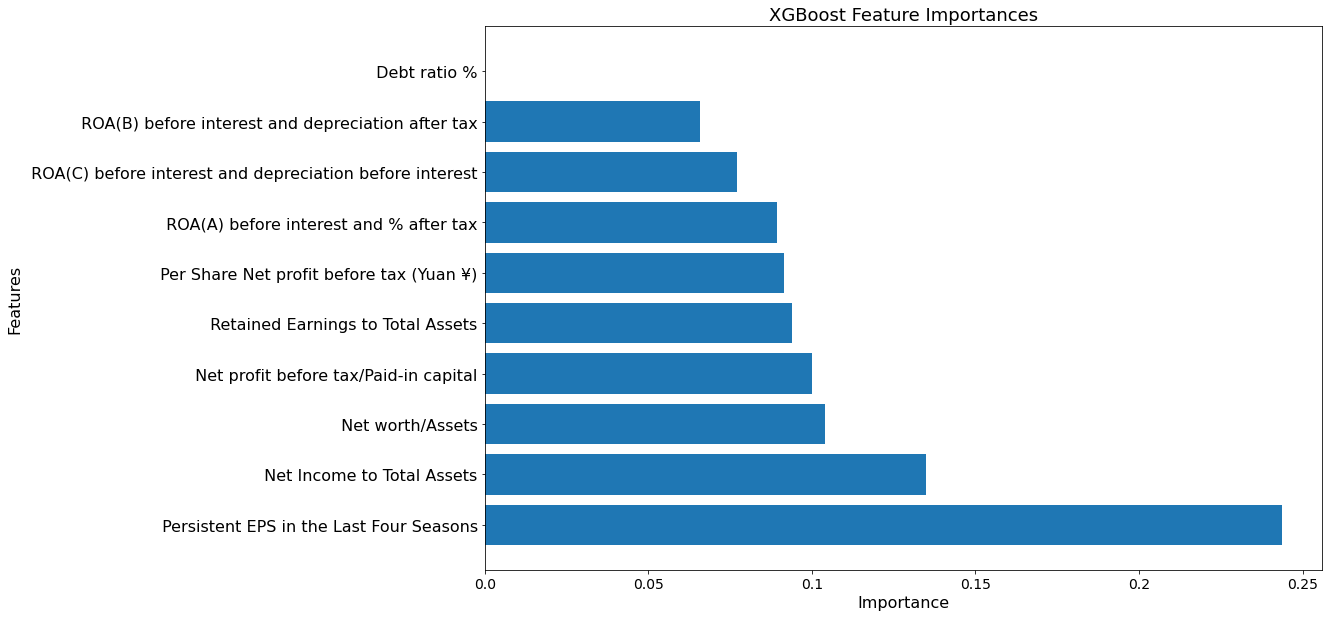

In [ ]:
#plt.style.use("dark_background")
#sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(df_10_sorted['Features'], df_10_sorted['importance'])
ax.set_ylabel('Features', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('XGBoost Feature Importances', fontsize=18)
ax.set_yticklabels(labels=df_10_sorted['Features'], fontsize=16)
ax.set_xticklabels(labels=[0.0, 0.05,0.10, 0.15, 0.20, 0.25, 0.30], fontsize=14)

## Validation

- Below we will calculate our precision and recall scores from our models using our testing data.

In [ ]:
precision_df = pd.DataFrame(precision_scores)
recall_df = pd.DataFrame(recall_scores)

In [ ]:
precision_1_df = precision_df.copy()
recall_1_df = recall_df.copy()

In [ ]:
precision_1_df['Baseline']['Test'] = precision_score(y_test, debt_pipeline.predict(X_test_debt))
recall_1_df['Baseline']['Test'] = recall_score(y_test, debt_pipeline.predict(X_test_debt))

In [ ]:
precision_1_df['Top 10']['Test'] = precision_score(y_test, top_10_pipeline.predict(X_test_top_10))
recall_1_df['Top 10']['Test'] = recall_score(y_test, top_10_pipeline.predict(X_test_top_10))

In [ ]:
precision_1_df['Random Forest']['Test'] = precision_score(y_test, rfc_best_balance.predict(X_test_top_10))
recall_1_df['Random Forest']['Test'] = recall_score(y_test, rfc_best_balance.predict(X_test_top_10))

In [ ]:
test_prob_pred_xgb = xgb_best_pipe.predict_proba(X_test_top_10)
test_prob_pred_xgb

array([[9.9978548e-01, 2.1451576e-04],
       [9.9779445e-01, 2.2055663e-03],
       [9.9828523e-01, 1.7147672e-03],
       ...,
       [9.9981135e-01, 1.8862382e-04],
       [9.5264453e-01, 4.7355488e-02],
       [3.0810833e-03, 9.9691892e-01]], dtype=float32)

In [ ]:
test_prob_0 = test_prob_pred_xgb[:,0]

In [ ]:
y_test_pred_xgb = np.where(test_prob_0 > .2, 0, 1)

In [ ]:
test_xgb_cf = confusion_matrix(y_test, y_test_pred_xgb)
test_xgb_cf

array([[1172,   38],
       [  22,   22]])

In [ ]:
precision_1_df['XGB Best']['Test'] = precision_score(y_test, y_test_pred_xgb)
recall_1_df['XGB Best']['Test'] = recall_score(y_test, y_test_pred_xgb)

## Plotting our scores
- Below we will plot our training and test precision and recall scores for our Baseline, Top 10 Features, Random Forest, XGBoost, and Catboost models.

In [ ]:
precision_1_df.drop(['Class Weight', 'Oversampling', 'Undersampling', 'All Features'], axis=1, inplace=True)

In [ ]:
precision_1_df

,Baseline,Top 10,Random Forest,XGB Best
Train,0.69,0.52,0.99,0.98
Test,1.00,0.50,0.57,0.37


In [ ]:
recall_1_df = recall_1_df.drop(['Class Weight', 'Oversampling', 'Undersampling', 'All Features'], axis=1)


Text(0.5, 1.0, 'Precision Test vs Train')

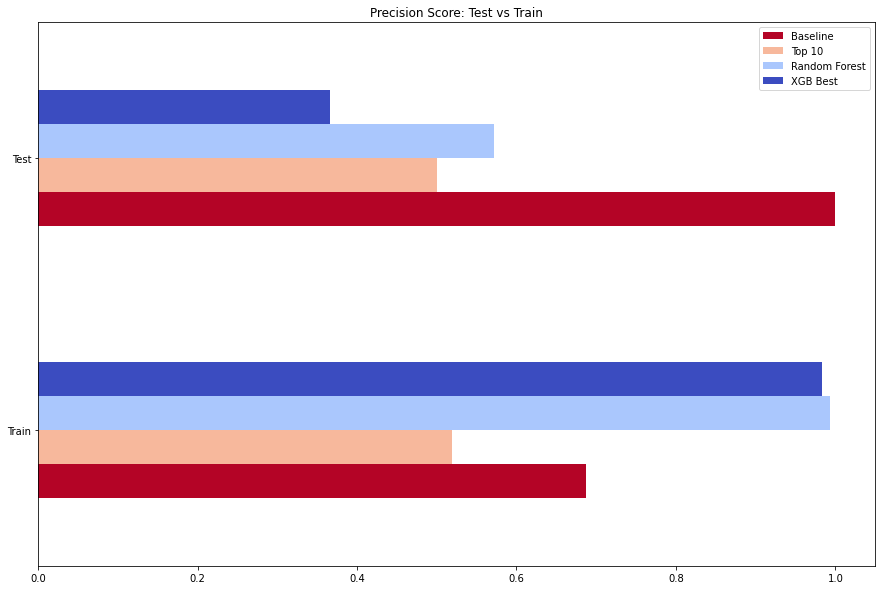

In [ ]:
precision_1_df.plot(kind='barh', figsize=(15,10),colormap='coolwarm_r', title='Precision Score: Test vs Train')
ax.set_title('Precision Test vs Train')


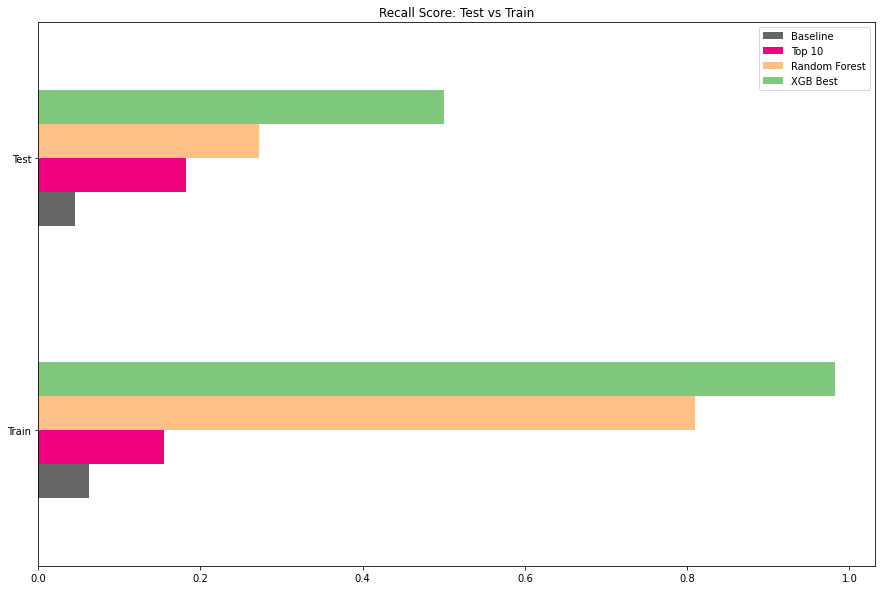

In [ ]:
recall_1_df.plot(kind='barh', figsize=(15, 10), colormap='Accent_r', title='Recall Score: Test vs Train')


#### Test Confusion Matrices

- Baseline Test Confusion Matrix

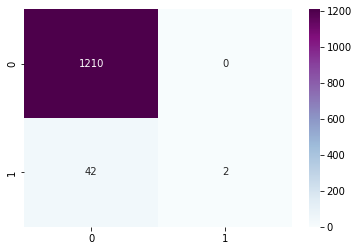

In [ ]:
Baseline_cf = confusion_matrix(y_test, debt_pipeline.predict(X_test_debt))
sns.heatmap(Baseline_cf, annot=True, fmt='d', cmap="BuPu");

- Top 10 Test Confusion Matrix

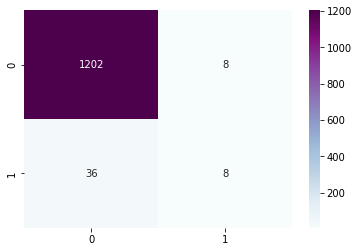

In [ ]:
top_10_cf = confusion_matrix(y_test, top_10_pipeline.predict(X_test_top_10))
sns.heatmap(top_10_cf, annot=True, fmt='d', cmap="BuPu");

- Random Forest Classifier Test Confusion Matrix

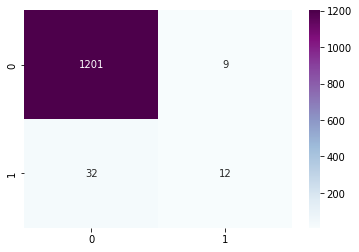

In [ ]:
rfc_cf = confusion_matrix(y_test, rfc_best_balance.predict(X_test_top_10))
sns.heatmap(rfc_cf, annot=True, fmt='d', cmap="BuPu");

- XGBoost with Threshold .8/ .2 Test Confusion Matrix

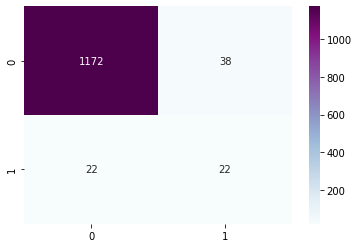

In [ ]:
sns.heatmap(test_xgb_cf, annot=True, fmt='d', cmap="BuPu")

- XGBoost confusion matrix without threshold

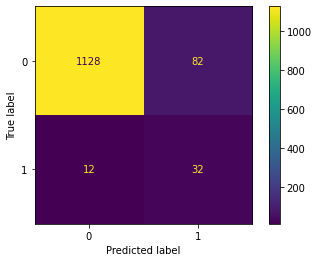

In [ ]:
plot_confusion_matrix(xgb_best_pipe, X_test_top_10, y_test);

Above, we can observe our Random Forest, CatBoost, and XGBoost models with a high training precision scores perform worse on the testing data, suggesting our models were overfit on the training data. Our recall scores for those three also dropped when we applied test data to the models.

## Final Analysis and Conclusion
We tuned our models towards precision to minimize Type I errors, also known as false positives. The model with the highest training precision score was our XGBoost model. When we ran this model on our testing set, it did not perform as well as on the training set. This might be because we did not include the threshold into cross validation. 


### Next Steps
Further analysis we could pursue to better predict bankruptcy in Taiwan: 
- We can manually run Stratified K Folding with threshold implementation to fix the threshold issue
- Add data and information such as dates of bankruptcy
- Continue to think of new parameters and different modelling strategies 